In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord, SkyOffsetFrame, Angle
import astropy.units as u
from astropy.visualization import ImageNormalize, AsinhStretch, LinearStretch, LogStretch
from scipy.ndimage import gaussian_filter
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, Rectangle, Circle
from astropy.coordinates import SkyCoord, SkyOffsetFrame, Angle
from astropy.wcs import WCS
from astropy.cosmology import Planck18
import astropy.units as u
from astropy.visualization import ImageNormalize, AsinhStretch
from scipy.ndimage import gaussian_filter

# continuumm image

In [307]:
from regions import Regions
from matplotlib.lines import Line2D
from astropy.wcs.utils import proj_plane_pixel_scales
import scienceplots
plt.style.use(["science",'no-latex'])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":10,
"legend.fancybox":True})
# === User parameters ===
folder="/disk/bifrost/yuanze/KBSS/Q1549/subaru/"
fits_path      = folder+"NBs3f_back64sub.fits"  # ~5GB file
#folder="/disk/bifrost/yuanze/KBSS/JWST_cycle5/"

#fits_path      = folder+"q1549G.fits"  # ~5GB file

center_icrs    = SkyCoord(237.96869*u.deg, 19.18452*u.deg)  # center RA/Dec (e.g., HS1549)
box_size_arcmin = 8.0    # total cutout width = height in arcmin (set to cover all footprints + margin)

# Binning (block-reduction). 4 or 8 are good starts. Must be integer.
bin_factor     = 2

# Smoothing sigma in *binned pixels*
sigma_pix      = 1.0

# Contours in sigma above background (robust RMS on the binned cutout)
levels_sigma   = [2, 3, 5, 10]

# Display stretch
use_asinh      = True

# Footprints (sizes in arcmin, PA east of north, centers in deg)
msa_params = dict(ra=237.987429, dec=19.1841291, w=3.6, h=3.4, pa=258.0)  # NIRSpec MSA
lwc_params = dict(ra=237.97402, dec=19.18614, w=2.2, h=2.2, pa=130.0)  # NIRCam LW (single module)

out_png        = "lya_contours_fast.png"
dpi            = 300
CS_TOKENS = {"fk5","icrs","galactic","ecliptic","image","physical"}

# -----------------------
# Helpers
# -----------------------
def is_shape_line(line):
    # crude but effective: matches typical DS9 region calls
    return bool(re.match(r"\s*(point|circle|box|ellipse|polygon)\s*\(", line, re.IGNORECASE))

def open_memmap_primary2d(path):
    hdul = fits.open(path, memmap=True)
    # find first 2D image
    hdu = None
    for h in hdul:
        if hasattr(h, "data") and isinstance(h.data, np.ndarray) and h.data.ndim == 2:
            hdu = h
            break
    if hdu is None:
        hdul.close()
        raise ValueError("No 2D image found.")
    return hdul, hdu

def world_box_to_pixel_bounds(wcs, center, box_size_arcmin, shape):
    # define a rotated-less box in a local tangent plane, then transform corners to ICRS, then to pixels
    off = SkyOffsetFrame(origin=center)
    half = (box_size_arcmin/2.0)*u.arcmin
    corners_off = SkyCoord([+half, +half, -half, -half],
                           [+half, -half, -half, +half],
                           frame=off)
    corners_icrs = corners_off.transform_to("icrs")
    xs, ys = wcs.world_to_pixel(corners_icrs)
    xmin = int(np.floor(np.nanmin(xs))); xmax = int(np.ceil(np.nanmax(xs)))
    ymin = int(np.floor(np.nanmin(ys))); ymax = int(np.ceil(np.nanmax(ys)))
    # clip to image bounds
    ny, nx = shape
    xmin = max(0, xmin); ymin = max(0, ymin)
    xmax = min(nx, xmax); ymax = min(ny, ymax)
    return xmin, xmax, ymin, ymax

def block_reduce_mean(img, factor):
    """Fast NxN mean binning without extra deps; masks NaNs."""
    if factor == 1:
        return img
    # trim edges to be divisible by factor
    ny, nx = img.shape
    ny2 = (ny // factor) * factor
    nx2 = (nx // factor) * factor
    trimmed = img[:ny2, :nx2]
    # reshape and mean with nan safety
    reshaped = trimmed.reshape(ny2//factor, factor, nx2//factor, factor)
    return np.nanmean(np.nanmean(reshaped, axis=3), axis=1)

def robust_bg_rms_subsample(arr, step=16, clip_sigma=3.0, iters=3):
    """Estimate background median and RMS from a sparse grid to avoid scanning all pixels."""
    sub = arr[::step, ::step]
    # sigma-clip by masking extreme outliers roughly
    x = sub[np.isfinite(sub)]
    for _ in range(iters):
        med = np.nanmedian(x)
        mad = np.nanmedian(np.abs(x - med))
        sig = 1.4826*mad if mad > 0 else np.nanstd(x)
        mask = np.abs(x - med) < clip_sigma*sig
        x = x[mask]
        if x.size == 0:
            break
    bkg = np.nanmedian(x) if x.size else np.nanmedian(sub)
    # robust RMS via MAD
    mad = np.nanmedian(np.abs(x - bkg)) if x.size else np.nanmedian(np.abs(sub - bkg))
    rms = 1.4826*mad
    return bkg, rms

def _rect_corners_world(center_ra_deg, center_dec_deg, width_arcmin, height_arcmin, pa_deg):
    c = SkyCoord(center_ra_deg*u.deg, center_dec_deg*u.deg, frame="icrs")
    off_frame = SkyOffsetFrame(origin=c, rotation=Angle(pa_deg, u.deg))
    dx = (width_arcmin/2.0) * u.arcmin
    dy = (height_arcmin/2.0) * u.arcmin
    corners_off = SkyCoord([ +dx, +dx, -dx, -dx ],
                           [ +dy, -dy, -dy, +dy ],
                           unit=u.arcmin, frame=off_frame)
    return corners_off.transform_to("icrs")

def add_rotated_footprint(ax, wcs, ra_deg, dec_deg, w_arcmin, h_arcmin, pa_deg,
                          label=None, edgecolor=None, lw=2.0, ls='-',
                          zorder=10, alpha=1.0):
    corners_icrs = _rect_corners_world(ra_deg, dec_deg, w_arcmin, h_arcmin, pa_deg)
    xs, ys = wcs.world_to_pixel(corners_icrs)
    poly = Polygon(np.c_[xs, ys], closed=True, fill=False,
                   edgecolor=edgecolor, linewidth=lw, linestyle=ls,
                   zorder=zorder, alpha=alpha)
    ax.add_patch(poly)
    if label:
        idx = np.argmax(ys)  # near top
        ax.text(xs[idx], ys[idx], f" {label}", fontsize=9, weight='bold',
                va='bottom', ha='left', color=edgecolor, zorder=zorder+1,
                bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', pad=2))
def add_scalebar(ax, wcs, length_arcmin=5.0, loc="lower left",
                 pad_frac=0.03, color="white", lw=2.0, fontsize=10,
                 label=None, box=True):
    """
    Draw a horizontal scale bar with length `length_arcmin` on a WCSAxes image.

    Parameters
    ----------
    ax : matplotlib axes (WCSAxes)
    wcs : astropy.wcs.WCS
    length_arcmin : float
        Desired angular length of the scale bar (arcmin).
    loc : str
        One of {"lower left","lower right","upper left","upper right"}.
    pad_frac : float
        Padding from edges as a fraction of axis width/height (in data/pixel coords).
    color : str
        Line/text color.
    lw : float
        Line width.
    fontsize : int
        Label font size.
    label : str or None
        Custom label string. If None, uses e.g. "5′".
    box : bool
        If True, draw a faint white box behind the label for readability.
    """
    # pixel scales in deg/pixel along x,y
    sx_deg, sy_deg = proj_plane_pixel_scales(wcs)  # array([deg/pix_x, deg/pix_y])
    length_deg = (length_arcmin / 60.0)
    # convert desired angular length to pixels along x
    length_pix = length_deg / sx_deg

    # pick a corner position in pixel/data coordinates
    xlo, xhi = ax.get_xlim()
    ylo, yhi = ax.get_ylim()
    xmin, xmax = (min(xlo, xhi), max(xlo, xhi))
    ymin, ymax = (min(ylo, yhi), max(ylo, yhi))
    W = xmax - xmin
    H = ymax - ymin
    pad_x = pad_frac * W
    pad_y = pad_frac * H

    if "lower" in loc:
        y0 = ymin + pad_y
        va = "bottom"
        y_text = y0 + 0.02*H  # a hair below the line
    else:
        y0 = ymax - pad_y
        va = "top"
        y_text = y0 - 0.02*H

    if "left" in loc:
        x0 = xmin + pad_x
        x1 = x0 + length_pix
    else:
        x1 = xmax - pad_x
        x0 = x1 - length_pix

    # draw the bar (horizontal in pixel coords)
    ax.plot([x0, x1], [y0, y0], color=color, lw=lw, solid_capstyle="butt", zorder=50)
    # optional end caps
    cap = 0.012 * H
    ax.plot([x0, x0], [y0-cap, y0+cap], color=color, lw=lw, zorder=50)
    ax.plot([x1, x1], [y0-cap, y0+cap], color=color, lw=lw, zorder=50)

    # label
    if label is None:
        label = f"{length_arcmin:g}\N{PRIME}"  # e.g. 5′
    bbox = dict(facecolor="white", alpha=0.6, edgecolor="none", pad=2) if box else None
    ax.text(0.5*(x0+x1), y_text, label, color=color, ha="center", va=va,
            fontsize=fontsize, weight="bold", bbox=bbox, zorder=51)
def add_msa_quadrants(ax, wcs, ra_deg, dec_deg, w_arcmin, h_arcmin, pa_deg,
                      edgecolors=("tab:blue","tab:orange","tab:green","tab:purple"),
                      labels=("Q1","Q2","Q3","Q4"),
                      lw=1.5, ls='-', alpha=0.9, zorder=11, fill=False, facealpha=0.08):
    """
    Draw the 4 MSA quadrants as separate rotated rectangles.

    Quadrant sizes: (w/2) x (h/2)
    Quadrant centers: offset by +/- w/4 along PA (width axis) and +/- h/4 along PA+90° (height axis).
    PA is degrees east of north (astronomical convention), same as your footprint.
    """
    # main center and PA (in radians for directional offsets)
    cen = SkyCoord(ra_deg*u.deg, dec_deg*u.deg, frame="icrs")
    pa_rad = np.deg2rad(pa_deg)

    # half-size of each quadrant
    wq = (w_arcmin/2.0)
    hq = (h_arcmin/2.0)

    # offsets from the main center to each quadrant center
    dx = (w_arcmin/4.0)*u.arcmin   # along PA (width axis)
    dy = (h_arcmin/4.0)*u.arcmin   # along PA+90° (height axis)

    # signs for the four quadrants: (+x,+y), (-x,+y), (-x,-y), (+x,-y)
    # (order chosen to map colors/labels to Q1..Q4 consistently)
    offsets = [(+1, +1), (-1, +1), (-1, -1), (+1, -1)]

    quads = []
    for (sx, sy), color, lab in zip(offsets, edgecolors, labels):
        # move from main center first along PA, then perpendicular
        qcen = cen.directional_offset_by(pa_rad, sx*dx)
        qcen = qcen.directional_offset_by(pa_rad + np.pi/2.0, sy*dy)

        # corners of this quadrant (still rotated by the global PA)
        corners_icrs = _rect_corners_world(qcen.ra.deg, qcen.dec.deg, wq, hq, pa_deg)
        xs, ys = wcs.world_to_pixel(corners_icrs)

        poly = Polygon(np.c_[xs, ys], closed=True,
                       fill=fill, facecolor=color if fill else "none",
                       edgecolor=color, linewidth=lw, linestyle=ls,
                       alpha=alpha if not fill else facealpha,
                       zorder=zorder)
        ax.add_patch(poly)

        # label near top edge of this small box
        idx_top = np.argmax(ys)
        #ax.text(xs[idx_top], ys[idx_top], f" {lab}", fontsize=8, weight='bold',
        #        va='bottom', ha='left', color=color, zorder=zorder+1,
        #        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', pad=1.5))

        quads.append(poly)

    return quads  # in case you want to add to a legend
def ds9_line_meta(line, default_color=None):
    """
    Extract (shape, color, text) from a single DS9 region line.
    Works even if astropy-regions loses .meta/.visual.
    """
    # Split off options after '#'
    if "#" in line:
        geom, opts = line.split("#", 1)
    else:
        geom, opts = line, ""

    shape_match = re.match(r"\s*(point|circle|box|ellipse|polygon)\s*\(", geom, re.IGNORECASE)
    shape = shape_match.group(1).lower() if shape_match else ""

    # color=..., hex or name
    color = default_color
    mcol = re.search(r"color\s*=\s*([#\w]+)", opts, re.IGNORECASE)
    if mcol:
        color = mcol.group(1).strip().lower()

    # text={...} capturing braces content, DS9 allows spaces
    mtxt = re.search(r"text\s*=\s*\{([^}]*)\}", opts, re.IGNORECASE)
    text = mtxt.group(1).strip() if mtxt else ""

    return shape, color, text

def load_ds9_with_meta(path):
    """
    Returns:
      regions_geo: Regions object (geometry only, from astropy-regions)
      metas: list of dicts (shape/color/text) aligned to regions_geo order
    """
    with open(path, "r", encoding="utf-8") as f:
        lines = [ln.strip() for ln in f if ln.strip() and not ln.strip().startswith("//")]

    # Track state: coord system blocks & default global color
    default_color = None
    cur_cs = None
    shape_lines = []
    metas = []

    for ln in lines:
        low = ln.lower()
        if low.startswith("global"):
            # capture default color from global line if present
            mcol = re.search(r"color\s*=\s*([#\w]+)", ln, re.IGNORECASE)
            if mcol:
                default_color = mcol.group(1).strip().lower()
            continue
        # coord system lines are single tokens, e.g., 'fk5'
        if low in CS_TOKENS:
            cur_cs = low
            shape_lines.append(ln)  # keep CS token for regions parser
            continue

        if is_shape_line(low):
            # keep the exact geometry line (plus options) for astropy-regions
            shape_lines.append(ln)
            shape, color, text = ds9_line_meta(ln, default_color)
            metas.append({"shape": shape, "color": color, "text": text, "cs": cur_cs})

    # Build geometry with astropy-regions (ignores/loses meta in some versions)
    regions_geo = Regions.parse("\n".join(shape_lines), format="ds9")
    # Remove meta entries corresponding to non-shape lines (e.g., cs tokens)
    # regions_geo only contains shapes, so filter metas to same count:
    # metas currently only for shapes, so lengths should match
    assert len([ln for ln in shape_lines if is_shape_line(ln)]) == len(metas), \
        "Meta/geometry misalignment — check DS9 formatting."
    return regions_geo, metas

def classify(shape, color):
    """
    Rules:
      - any point  -> 'SMG'
      - circle AND DS9 color 'darkgreen' (or hex close to darkgreen) -> 'QSO'
      - else -> 'LAE/galaxy'
    """

    if shape == "point":
        return "SMG"

    if shape == "circle":
        if color in ("darkgreen", "#006400", "#006401"):  # include common hex variant
            return "QSO"
        if color in ("green"):
            return "LAE"

    return "LBG"
ms=5
CLASS_STYLES = {
    "SMG":        dict(lw=1.,  marker="o",  ms=ms,alpha=0.6,  color="red"),
    "QSO":        dict(marker="D",color="magenta",ms=ms, lw=1.2,alpha=0.6),
    "LAE": dict(marker="s",color="deepskyblue",ms=ms, lw=1.2, alpha=0.6),
    "LBG": dict(marker="s",color="xkcd:lime green",ms=ms, lw=1.2, alpha=0.6)
}

LEGEND_HANDLES = [
    Line2D([0],[0], marker="o", linestyle="None",  ms=9,  color="red",      label="SMG"),
    Line2D([0],[0], marker="D", linestyle="None",  ms=9,color="magenta",   label="AGN"),
    Line2D([0],[0], marker="s", linestyle="None",  ms=9,color="deepskyblue",  label="LAE"),
    Line2D([0],[0], marker="s", linestyle="None",  ms=9,color="xkcd:lime green",  label="LBG"),
]

In [308]:

# -----------------------
# Pipeline
# -----------------------
# 1) Open as memmap; build WCS
hdul, hdu = open_memmap_primary2d(fits_path)
data = hdu.data  # memmapped
header = hdu.header
w = WCS(header)

# 2) Compute pixel bounds for requested sky box (no full read)
xmin, xmax, ymin, ymax = world_box_to_pixel_bounds(w, center_icrs, box_size_arcmin, data.shape)
cut = data[ymin:ymax, xmin:xmax].astype(np.float32)  # bring only needed piece into RAM, cast to float32 to save memory

# 3) Replace extreme invalids with NaN
cut[~np.isfinite(cut)] = np.nan

# 4) Block-reduce (bin) to shrink image massively before smoothing/plotting
binned = block_reduce_mean(cut, bin_factor)

# 5) Robust background on binned image via subsampling (fast)
bkg, rms = robust_bg_rms_subsample(binned, step=max(4, 512//max(1, binned.shape[0]//1024)))

# 6) Background subtract (helpful for contour levels), smooth
binned_bs = binned - bkg
smoothed = gaussian_filter(binned_bs, sigma=sigma_pix, mode="nearest")

# 7) Contour levels in absolute (post-subtraction) units
levels = np.array(levels_sigma, dtype=float) * rms

# 8) Build WCS for the cutout and adjust for binning so footprints land correctly
#    WCS for the cut (shift CRPIX), then scale CD matrix by bin_factor
w_cut = w.deepcopy()
# shift reference pixel: cropping moves origin by (xmin, ymin)
# CRPIX_new = CRPIX_old - [xmin, ymin]
crpix1 = w_cut.wcs.crpix[0] - xmin
crpix2 = w_cut.wcs.crpix[1] - ymin
w_cut.wcs.crpix = [crpix1, crpix2]
# Now account for binning: scale CD (or CDELT) by bin_factor and shift CRPIX by /bin_factor
if w_cut.wcs.has_cd():
    w_cut.wcs.cd *= bin_factor
else:
    # CDELT/CROTA form
    w_cut.wcs.cdelt *= bin_factor
w_cut.wcs.crpix = [crpix1/bin_factor, crpix2/bin_factor]



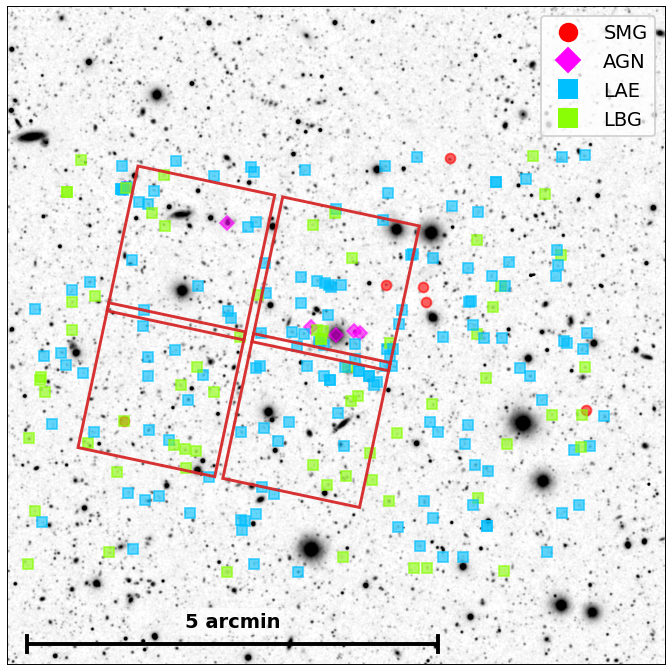

[OK] Saved: lya_contours_fast.png
[INFO] Cutout shape (pix): (2859, 2859), binned: (1429, 1429), vmin/vmax=-1.04e-13/8.87e-12, RMS=1.21e-13


In [312]:
# 9) Plot
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(111)#, #projection=w_cut.celestial)
#ax.set_xlabel("RA")
#ax.set_ylabel("Dec")

# Display normalization
finite = np.isfinite(smoothed)
vmin, vmax = np.nanpercentile(smoothed[finite], [5, 99.5])
norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=AsinhStretch() if use_asinh else LinearStretch())

im = ax.imshow(smoothed, origin="lower", norm=norm, rasterized=True,cmap="gray_r")
#cs = ax.contour(smoothed, levels=levels, linewidths=1.2, colors="white")

#cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
#cbar.set_label("Flux (relative units, bkg-subtracted)")

#ax.set_title(f"{fits_path}  |  cut {box_size_arcmin:.1f}'  |  bin×{bin_factor}  |  σ_smooth={sigma_pix:.1f}px")

# 10) Overlays (use *cutout WCS* so labels align)
#add_rotated_footprint(ax, w_cut, msa_params['ra'], msa_params['dec'],
#                      msa_params['w'], msa_params['h'], msa_params['pa'],
#                       edgecolor='tab:red', lw=2.0)#label="NIRSpec MSA",
add_msa_quadrants(ax, w_cut,
                  msa_params['ra'], msa_params['dec'],
                  msa_params['w'], msa_params['h'], msa_params['pa'],
                  edgecolors=("tab:red","tab:red","tab:red","tab:red"),
                  #labels=,
                  lw=1.5, alpha=0.95, fill=False)
#add_rotated_footprint(ax, w_cut, lwc_params['ra'], lwc_params['dec'],
#                      lwc_params['w'], lwc_params['h'], lwc_params['pa'],
#                      label="NIRCam LW (~2.2'×2.2')", edgecolor='tab:blue', lw=2.0, ls='--')

# --- read and draw regions ---
regions_path="/disk/bifrost/yuanze/KBSS/JWST_cycle5/primary_targets.reg"
regs_geo, metas = load_ds9_with_meta(regions_path)
for r, m in zip(regs_geo, metas):
    clas = classify(m["shape"], m["color"])
   # counts[clas] += 1
    
    # convert to pixels for plotting on this WCS
    rp = r.to_pixel(w_cut)
    #if clas == "QSO":
    #    print(m)
    #    print(rp)
    style = CLASS_STYLES[clas]
    ax.plot(rp.center.x,rp.center.y,
            color=style.get("color", "white"),
            #edgecolor=style.get("edgecolor", "white"),
            #facecolor=style.get("facecolor", "none"),
            marker=style.get("marker", "o"),
            ms=style.get("ms", "10"),
            lw=style.get("lw", 1.2),
            alpha=style.get("alpha", 1.0))
    #if m["text"] and hasattr(rp, "center"):
        #ax.text(rp.center.x, rp.center.y, f" {m['text']}",
               # color=style.get("color", "white"),
               # fontsize=8, va="bottom", ha="left", alpha=0.95)
xqso,yqso = w_cut.world_to_pixel(center)
ax.plot(xqso,yqso,marker="D",color="magenta",ms=5,alpha=0.6)

ax.legend(handles=LEGEND_HANDLES, loc="upper right", frameon=True)

ax.tick_params(axis='both',which="major", length=0)
ax.tick_params(axis='both',which="minor", length=0)

#ax.coords['ra'].set_axislabel(None)
#ax.coords['dec'].set_axislabel(None)
#axticks=np.arange(600,3800,600)
#ax.set_xticks(axticks)
#ax.set_yticks(axticks)

#axlabels1=np.arange(-25,26,10,dtype=int)
#axlabels2=np.arange(25,-26,-10,dtype=int)

ax.set_xticklabels("")
ax.set_yticklabels("")
#ax.set_ylabel(r"$\Delta$arcmin")
#ax.set_xlabel(r"$\Delta$arcmin")
add_scalebar(ax, w_cut, length_arcmin=5.0, label="5 arcmin",loc="lower left", color="k", lw=2)

plt.tight_layout()
plt.savefig(out_png, dpi=dpi, bbox_inches="tight")
plt.show()

# clean up HDU to release file handle
hdul.close()

print(f"[OK] Saved: {out_png}")
print(f"[INFO] Cutout shape (pix): {cut.shape}, binned: {binned.shape}, vmin/vmax={vmin:.3g}/{vmax:.3g}, RMS={rms:.3g}")


In [259]:
clas

'LBG'

376.57011734337453

# LAE map

## Define helper functions

In [16]:
def world_box_to_pixel_bounds(wcs, center, box_size_arcmin, shape):
    # define a rotated-less box in a local tangent plane, then transform corners to ICRS, then to pixels
    off = SkyOffsetFrame(origin=center)
    half = (box_size_arcmin/2.0)*u.arcmin
    corners_off = SkyCoord([+half, +half, -half, -half],
                           [+half, -half, -half, +half],
                           frame=off)
    corners_icrs = corners_off.transform_to("icrs")
    xs, ys = wcs.world_to_pixel(corners_icrs)
    xmin = int(np.floor(np.nanmin(xs))); xmax = int(np.ceil(np.nanmax(xs)))
    ymin = int(np.floor(np.nanmin(ys))); ymax = int(np.ceil(np.nanmax(ys)))
    # clip to image bounds
    ny, nx = shape
    xmin = max(0, xmin); ymin = max(0, ymin)
    xmax = min(nx, xmax); ymax = min(ny, ymax)
    return xmin, xmax, ymin, ymax
def parse_attr_dict(trailing):
    """
    Parse the attribute substring after '#' into a dict.
    Example: "point=box 18 color=#00DD00 width=2"
    Returns: {"point": "box", "point_size": "18", "color": "#00DD00", "width": "2"}
    """
    attrs = {}
    if trailing is None:
        return attrs
    # split by whitespace, but treat key=value pairs
    tokens = trailing.strip().split()
    i = 0
    while i < len(tokens):
        tok = tokens[i]
        if "=" in tok:
            key, val = tok.split("=", 1)
            attrs[key.lower()] = val
        else:
            # handle patterns like "point=box 18" (size after symbol)
            if tok.lower().startswith("point="):
                # already handled
                pass
            else:
                # if previous key was "point" and current token looks like a number -> size
                if "point" in attrs and "point_size" not in attrs:
                    # numeric?
                    try:
                        float(tok)
                        attrs["point_size"] = tok
                    except ValueError:
                        pass
        i += 1
    return attrs

def parse_ds9_lae_lab(path):
    re_point = re.compile(r"point\(\s*([0-9:\.\+\-]+)\s*,\s*([0-9:\.\+\-]+)\s*\)", re.IGNORECASE)

    """
    Return (SkyCoord LAEs, SkyCoord LABs) based on:
      LAE: point=cross or color contains 'cyan'
      LAB: point=box  or color equals '#00DD00'
    """
    lae_ra, lae_dec = [], []
    lab_ra, lab_dec = [], []
    with open(path, "r") as f:
        for line in f:
            line = line.strip()
            if line.lower().startswith("#") or len(line) == 0:
                continue
            m = re_point.search(line)
            if not m:
                continue
            ra_str, dec_str = m.group(1), m.group(2)

            # attributes after '#'
            parts = line.split("#", 1)
            attrs = parse_attr_dict(parts[1] if len(parts) > 1 else None)
            point_sym = attrs.get("point", "").lower()
            color = attrs.get("color", "").lower()

            # Determine class
            is_lae = (point_sym == "cross") or ("cyan" in color)
            is_lab = (point_sym == "box") or (color == "#00dd00")

            # Ignore ambiguous lines that are neither
            if not (is_lae or is_lab):
                continue

            # Parse coordinates (allow RA in HMS)
            try:
                sc = SkyCoord(ra_str, dec_str, unit=(u.hourangle, u.deg), frame="icrs")
            except Exception:
                sc = SkyCoord(float(ra_str)*u.deg, float(dec_str)*u.deg, frame="icrs")

            if is_lae and not is_lab:
                lae_ra.append(sc.ra.deg); lae_dec.append(sc.dec.deg)
            elif is_lab and not is_lae:
                lab_ra.append(sc.ra.deg); lab_dec.append(sc.dec.deg)
            else:
                # If both rules match (unlikely), prioritize LAB classification
                lab_ra.append(sc.ra.deg); lab_dec.append(sc.dec.deg)

    lae_coords = SkyCoord(lae_ra*u.deg, lae_dec*u.deg) if lae_ra else None
    lab_coords = SkyCoord(lab_ra*u.deg, lab_dec*u.deg) if lab_ra else None
    return lae_coords, lab_coords

def make_blank_wcs(center, box_size_arcmin, pixscale_arcsec):
    npix = int(np.ceil((box_size_arcmin*60.0)/pixscale_arcsec))
    w = WCS(naxis=2)
    cd = np.array([[-pixscale_arcsec/3600.0, 0.0],
                   [0.0,  pixscale_arcsec/3600.0]])
    w.wcs.cd = cd
    w.wcs.crval = [center.ra.deg, center.dec.deg]
    w.wcs.crpix = [npix/2.0 + 0.5, npix/2.0 + 0.5]
    w.wcs.ctype = ["RA---TAN", "DEC--TAN"]
    return w, npix

def rect_corners_world(ra_deg, dec_deg, w_arcmin, h_arcmin, pa_deg):
    c = SkyCoord(ra_deg*u.deg, dec_deg*u.deg, frame="icrs")
    off = SkyOffsetFrame(origin=c, rotation=Angle(pa_deg, u.deg))
    dx = (w_arcmin/2.0)*u.arcmin; dy = (h_arcmin/2.0)*u.arcmin
    corners_off = SkyCoord([ +dx, +dx, -dx, -dx ],
                           [ +dy, -dy, -dy, +dy ],
                           unit=u.arcmin, frame=off)
    return corners_off.transform_to("icrs")

def read_points_and_circles_from_ds9(path):
    re_point = re.compile(r"point\(\s*([0-9:\.\+\-]+)\s*,\s*([0-9:\.\+\-]+)\s*\)", re.IGNORECASE)
    re_circle = re.compile(r"circle\(\s*([0-9:\.\+\-]+)\s*,\s*([0-9:\.\+\-]+)\s*,\s*([0-9\.]+)([\"\']|[drajp]+)?\s*\)", re.IGNORECASE)
    re_text = re.compile(r"text\s*=\s*\{([^}]*)\}", re.IGNORECASE)
    """Parse point(...) and circle(...). Return (SkyCoord points, labels), and list of circle specs."""
    pts, labels = [], []
    circs = []  # list of dicts: ra, dec, r_arcsec
    with open(path, "r") as f:
        for line in f:
            mp = re_point.search(line)
            mc = re_circle.search(line)
            mtxt = re_text.search(line)
            label = mtxt.group(1).strip() if mtxt else None
            #labels.append(label)
            if mp:
                ra_str, dec_str = mp.group(1), mp.group(2)
                try:
                    sc = SkyCoord(ra_str, dec_str, unit=(u.hourangle, u.deg), frame="icrs")
                except Exception:
                    sc = SkyCoord(float(ra_str)*u.deg, float(dec_str)*u.deg, frame="icrs")
                pts.append(sc)
            elif mc:
                ra_str, dec_str, rad_val, unit = mc.groups()
                try:
                    sc = SkyCoord(ra_str, dec_str, unit=(u.hourangle, u.deg), frame="icrs")
                except Exception:
                    sc = SkyCoord(float(ra_str)*u.deg, float(dec_str)*u.deg, frame="icrs")
                # radius units: default in DS9 is degrees if not specified; we map '"'(arcsec) or "'"(arcmin)
                if unit == '"':
                    r = float(rad_val) * u.arcsec
                elif unit == "'":
                    r = float(rad_val) * u.arcmin
                else:
                    r = float(rad_val) * u.deg
                circs.append(dict(ra=sc.ra.deg, dec=sc.dec.deg, r_arcsec=r.to_value(u.arcsec),label=label))
    #pts_coord = SkyCoord([p.ra.deg for p in pts]*u.deg, [p.dec.deg for p in pts]*u.deg) if pts else SkyCoord([],[],unit=(u.deg,u.deg))
    circs_coord = SkyCoord([p["ra"] for p in circs]*u.deg, [p["dec"] for p in circs]*u.deg) if circs else SkyCoord([],[],unit=(u.deg,u.deg))
    return circs_coord, labels, circs

def add_rotated_footprint(ax, wcs, ra_deg, dec_deg, w_arcmin, h_arcmin, pa_deg,
                          label=None, edgecolor='tab:red', lw=2.0, ls='-',
                          zorder=10, alpha=1.0):
    cs = rect_corners_world(ra_deg, dec_deg, w_arcmin, h_arcmin, pa_deg)
    xs, ys = wcs.world_to_pixel(cs)
    poly = Polygon(np.c_[xs, ys], closed=True, fill=False,
                   edgecolor=edgecolor, linewidth=lw, linestyle=ls,
                   zorder=zorder, alpha=alpha)
    ax.add_patch(poly)
    if label:
        idx = np.argmax(ys)
        ax.text(xs[idx], ys[idx], f" {label}", fontsize=8, weight='bold',
                va='bottom', ha='left', color=edgecolor, zorder=zorder+1,
                bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', pad=2))


## Generate/plot a figure that shows the selected region wihtin a box

In [194]:



# =========================
# User params (edit me)
# =========================
folder="/disk/bifrost/yuanze/KBSS/Q1549/subaru/"
ds9_region_path_smg = folder+"/smg_sources.reg"      # DS9 with SMGs (point or circle); set to None if not available
ds9_region_path_agn = folder+"/AGN_sources.reg"      # DS9 with SMGs (point or circle); set to None if not available

ds9_region_path=folder+"/hs1549_lae_lab_smg_nircam.reg"
# Map (blank canvas) center & size to cover your field
center = SkyCoord(ra=237.96869*u.deg, dec=19.18452*u.deg)   # HS1549 example
box_size_arcmin = 70.0        # total width=height in arcmin
pixscale_arcsec = 1.0        # pixel scale for the density map (arcsec/pix)

# Smoothing for density (Gaussian kernel, FWHM in arcsec)
fwhm_smooth_arcsec = 150.0


# LAB box drawing
lab_box_size_arcsec = 50.0          # side length of the square marker for LABs (visual only)
lab_edgecolor = "blue"
lab_linewidth = 1.0

# Marker styling
smg_marker      = "x"            # "x", "+", "o" (circle), etc.
smg_markersize  = 90             # points^2 for 'scatter' (adjust bigger/smaller)
smg_edgewidth   = 1.6
smg_color       = "red"       # marker/edge color
smg_show_circle = False          # draw DS9 'circle()' radii as faint outlines
smg_label_fontsize = 8


# Footprints (sizes in arcmin, PA east of north, centers in deg)
msa_base = dict(ra=237.96869, dec=19.18452, w=7.1, h=5.2, pa=0.0)  # indicated box region
lwc_base = dict(ra=237.97402, dec=19.18614, w=2.2, h=2.2, pa=30.0)  # NIRCam LW (single module)

# Extra MSA footprints to highlight (optional)
extra_msa_list = [
     dict(ra=238.07395, dec=19.1883, w=3.6, h=3.4, pa=45.0),#, label="MSA-2"),
     dict(ra=238.01375, dec=19.190635, w=3.6, h=3.4, pa=45.0)#, label="MSA-3"),
]

# --------------------
# SMG markers
# --------------------
smg_coords = None
smg_labels = None
smg_circles = []
if ds9_region_path_smg:
    smg_coords, smg_labels, smg_circles = read_points_and_circles_from_ds9(ds9_region_path_smg)

agn_circles = []
if ds9_region_path_agn:
    _,_, agn_circles = read_points_and_circles_from_ds9(ds9_region_path_agn)
out_png = "lae_density_LAB_boxes_with_footprints.pdf"
dpi = 300

# --------------------
# Parsers & helpers
# --------------------
re_point = re.compile(r"point\(\s*([0-9:\.\+\-]+)\s*,\s*([0-9:\.\+\-]+)\s*\)", re.IGNORECASE)


# --------------------
# Parse DS9 and separate LAEs vs LABs
# --------------------
lae_coords, lab_coords = parse_ds9_lae_lab(ds9_region_path)
if lae_coords is None or len(lae_coords) == 0:
    raise ValueError("No LAEs parsed with (point=cross or color=cyan). Check DS9 file or parsing rules.")

# --------------------
# Build WCS canvas and LAE density
# --------------------
w, npix = make_blank_wcs(center, box_size_arcmin, pixscale_arcsec)
xpix, ypix = w.world_to_pixel(lae_coords)
H, yedges, xedges = np.histogram2d(ypix, xpix, bins=npix,
                                   range=[[0, npix], [0, npix]])

sigma_pix = (fwhm_smooth_arcsec / pixscale_arcsec) / 2.355
density = gaussian_filter(H, sigma=sigma_pix, mode="nearest")

pix_area_arcmin2 = (pixscale_arcsec/60.0)**2
density_per_arcmin2 = density / pix_area_arcmin2
density_per_pMpc2 = density_per_arcmin2/(Planck18.kpc_proper_per_arcmin(2.84)*1e-3)**2


/tmp/ipykernel_1587442/706549510.py:23: UserWarning: The following kwargs were not used by contour: 'ls'
  cs = ax.contour(density_per_arcmin2, levels=levels_per_arcmin2, colors="black", linewidths=0.7,ls="--")


specObjID    4426102289313585152
ra                      237.9686
dec                    19.184459
z                       2.822553
class                        QSO
subClass               BROADLINE
plate                       3931
mjd                        55350
fiberID                      690
Name: 21, dtype: object
specObjID    4426102564191492096
ra                      238.0087
dec                    19.143138
z                       2.824537
class                        QSO
subClass                     NaN
plate                       3931
mjd                        55350
fiberID                      691
Name: 22, dtype: object
specObjID    4426102014435678208
ra                     238.22273
dec                    19.097223
z                       2.855354
class                        QSO
subClass               BROADLINE
plate                       3931
mjd                        55350
fiberID                      689
Name: 23, dtype: object
specObjID    4426126203691489280
ra  

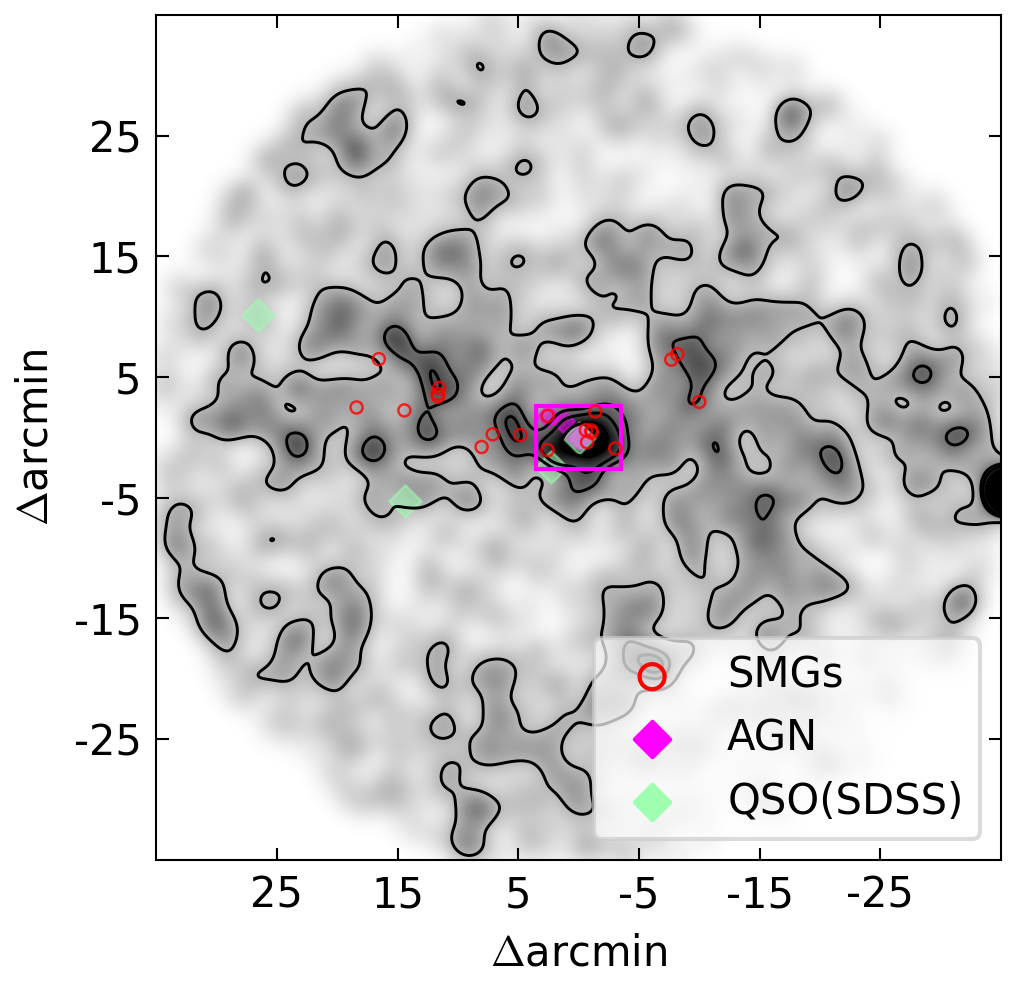

In [198]:
import scienceplots
plt.style.use(["science",'no-latex'])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":10,
"legend.fancybox":True})
# --------------------
# Plot
# --------------------
fig = plt.figure(figsize=(4, 3.5),dpi=300)
ax = plt.subplot(111)#, projection=w.celestial)
#ax.set_xlabel("RA"); ax.set_ylabel("Dec")
# Background image for context
mask_pos = density_per_arcmin2 > 0
vmin, vmax = (np.percentile(density_per_arcmin2[mask_pos], [5, 99.5]) if np.any(mask_pos) else (0, 1))
norm = ImageNormalize(vmin=vmin, vmax=vmax*1.3, stretch=LinearStretch())
im = ax.imshow(density_per_arcmin2, origin="lower", norm=norm,cmap="gray_r")

# Contour levels (in LAEs per square arcmin, approx—see note below)
levels_per_arcmin2 = [1.0,2.0,2.5, 3.5]
# LAE surface-density contours
cs = ax.contour(density_per_arcmin2, levels=levels_per_arcmin2, colors="black", linewidths=0.7,ls="--")
#ax.clabel(cs, inline=True, fontsize=8, fmt=lambda v: f"{v:.0f} LAE/arcmin²")

# Draw LABs as squares (boxes)
#if lab_coords is not None and len(lab_coords) > 0:
    # draw each as a square of given size in arcsec
#    half = (lab_box_size_arcsec/2.0) / pixscale_arcsec  # in pixels on our canvas
#    xs, ys = w.world_to_pixel(lab_coords)
#    for x, y in zip(xs, ys):
#        rect = Rectangle((x-half, y-half), width=2*half, height=2*half,
#                         angle=0.0, fill=False, linewidth=lab_linewidth,
#                         edgecolor=lab_edgecolor, zorder=15)
#        ax.add_patch(rect)
# optional legend tick
#ax.scatter([], [], marker='s', facecolors='none', edgecolors=lab_edgecolor,
#           linewidths=lab_linewidth, label="LABs")

# Footprints
add_rotated_footprint(ax, w, msa_base['ra'], msa_base['dec'], msa_base['w'], msa_base['h'], 0,#m#sa_base['pa'],
                       edgecolor='magenta', lw=1.0)#label="Proposal target region",
#add_rotated_footprint(ax, w, lwc_base['ra'], lwc_base['dec'], lwc_base['w'], lwc_base['h'], lwc_base['pa'],
#                      label="NIRCam LW", edgecolor='tab:blue', lw=2.0, ls='--')

# Extra MSA footprints
#for i, fp in enumerate(extra_msa_list, 1):
#    add_rotated_footprint(ax, w, fp['ra'], fp['dec'], fp['w'], fp['h'], fp['pa'],
#                           edgecolor='tab:red', lw=2.0, ls='-')
#label=fp.get('label', f"MSA-{i+1}"),
# SMG markers (points)
if smg_circles is not None and len(smg_circles) > 0:
    for c in smg_circles:
        cen = SkyCoord(c['ra']*u.deg, c['dec']*u.deg)
        x0, y0 = w.world_to_pixel(cen)
        # radius in pixels:
        r_pix = (30 / pixscale_arcsec)
        circ = Circle((x0, y0), radius=r_pix, fill=False, linestyle='-', linewidth=0.6,
                      edgecolor=smg_color, alpha=0.8, zorder=19)
        ax.add_patch(circ)
ax.scatter([], [], marker='o', facecolors='none', edgecolors=smg_color,
           linewidths=lab_linewidth, label="SMGs")
agn_color="magenta"
if agn_circles is not None and len(agn_circles) > 0:
    for c in agn_circles:
        cen = SkyCoord(c['ra']*u.deg, c['dec']*u.deg)
        x0, y0 = w.world_to_pixel(cen)
        # radius in pixels:
        r_pix = (30 / pixscale_arcsec)
        #circ = Circle((x0, y0), radius=r_pix, fill=False, linestyle='-', linewidth=0.6,
        #              edgecolor=agn_color, alpha=1.0, zorder=19)
        ax.scatter(x0,y0,s=r_pix/2,linewidth=0.6,facecolors=agn_color,marker="D",alpha=0.5)
        #ax.add_patch(circ)
ax.scatter([], [], marker='D', facecolors=agn_color,
           linewidths=lab_linewidth, label="AGN")

sdssqso_color="xkcd:mint"
if sdssqso is not None:
    for ind,c in sdssqso.iterrows():
        if c.z<2.75 or c.z>2.95:
            continue
        cen = SkyCoord(c['ra']*u.deg, c['dec']*u.deg)
        print(c)
        x0, y0 = w.world_to_pixel(cen)
        # radius in pixels:
        r_pix = (30 / pixscale_arcsec)
        #circ = Circle((x0, y0), radius=r_pix, fill=False, linestyle='-', linewidth=0.6,
        #              edgecolor=agn_color, alpha=1.0, zorder=19)
        ax.scatter(x0,y0,s=30,linewidth=0.6,facecolors=sdssqso_color,marker="D",alpha=0.5)
        #ax.add_patch(circ)
ax.scatter([], [], marker='D', facecolors=sdssqso_color,
           linewidths=lab_linewidth, label="QSO(SDSS)")
#xqso,yqso = w.world_to_pixel(center)
#ax.scatter(yqso,xqso,marker="*",color="y",s=20)
# Colorbar & cosmetics
#cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
#cbar.set_label("LAE surface density (per arcmin$^2$)")
#ttl = f"LAE Density (LAEs only) with LAB Boxes & Instrument Footprints\nFWHM={fwhm_smooth_arcsec:.0f}\"  |  pix={pixscale_arcsec:.1f}\"/pix  |  box={box_size_arcmin:.1f}'"
#ax.set_title(ttl)
ax.legend(loc="lower right", frameon=True, framealpha=0.7)

half_deg = (box_size_arcmin / 60.0) / 2.0
ra0, dec0 = center.ra.deg, center.dec.deg


    
xmin, xmax, ymin, ymax = world_box_to_pixel_bounds(w, center_icrs, box_size_arcmin, data.shape)

ax.set_xlim(0, xmax-xmin)   # RA decreases to the right
ax.set_ylim(0, ymax-ymin)
ax.tick_params(axis='both', which='minor', length=0)
#ax.coords['ra'].set_axislabel(None)
#ax.coords['dec'].set_axislabel(None)
axticks=np.arange(600,3800,600)
ax.set_xticks(axticks)
ax.set_yticks(axticks)

axlabels1=np.arange(-25,26,10,dtype=int)
axlabels2=np.arange(25,-26,-10,dtype=int)

ax.set_xticklabels(axlabels2)
ax.set_yticklabels(axlabels1)
ax.set_ylabel(r"$\Delta$arcmin")
ax.set_xlabel(r"$\Delta$arcmin")

plt.tight_layout()
plt.savefig(out_png, dpi=dpi, bbox_inches="tight")
#plt.show()

print(f"[OK] saved: {out_png}")
print(f"[INFO] LAE count: {len(lae_coords)} | LAB count: {0 if lab_coords is None else len(lab_coords)} | map: {npix}×{npix} px")

In [105]:
axlabels1

array([-25, -15,  -5,   5,  15,  25])

In [76]:
from astroquery.sdss import SDSS
import pandas as pd

ra, dec = center.ra.degree, center.dec.degree  # degrees
rad_arcmin = 30                 # 1 deg diameter = 0.5 deg radius = 30'

sql = f"""
SELECT s.specObjID, s.ra, s.dec, s.z, s.class, s.subClass, s.plate, s.mjd, s.fiberID
FROM SpecObj AS s
JOIN dbo.fGetNearbySpecObjEq({ra}, {dec}, {rad_arcmin}) AS nb
  ON s.specObjID = nb.specObjID
WHERE s.class='QSO' AND s.zWarning = 0
ORDER BY s.z
"""

tab = SDSS.query_sql(sql, data_release=18)   # pick your DR
sdssqso = tab.to_pandas()
print(df.head())

             specObjID         ra        dec         z class       subClass  \
0  2445530260054239232  237.70027  18.944974  0.166881   QSO      BROADLINE   
1  2445559946868189184  238.24086  19.422270  0.200535   QSO  AGN BROADLINE   
2  2445519814693775360  237.77028  19.332782  0.419699   QSO      BROADLINE   
3  4426112734674049024  238.11177  19.035139  0.573563   QSO      BROADLINE   
4  4426087171028703232  237.83519  19.616631  0.758314   QSO      BROADLINE   

   plate    mjd  fiberID  
0   2172  54230      275  
1   2172  54230      383  
2   2172  54230      237  
3   3931  55350      728  
4   3931  55350      635  


In [101]:
c

specObjID    4426126203691489280
ra                     238.43783
dec                    19.353434
z                         2.8985
class                        QSO
subClass                     NaN
plate                       3931
mjd                        55350
fiberID                      777
Name: 24, dtype: object

In [77]:
df

,specObjID,ra,dec,z,class,subClass,plate,mjd,fiberID
0,2445530260054239232,237.70027,18.944974,0.166881,QSO,BROADLINE,2172,54230,275
1,2445559946868189184,238.24086,19.422270,0.200535,QSO,AGN BROADLINE,2172,54230,383
2,2445519814693775360,237.77028,19.332782,0.419699,QSO,BROADLINE,2172,54230,237
3,4426112734674049024,238.11177,19.035139,0.573563,QSO,BROADLINE,3931,55350,728
4,4426087171028703232,237.83519,19.616631,0.758314,QSO,BROADLINE,3931,55350,635
5,4426109985894979584,238.15819,19.579811,0.854760,QSO,NaN,3931,55350,718
6,4426126478569396224,238.38670,19.097138,0.985403,QSO,BROADLINE,3931,55350,778
7,4426114933697304576,238.17396,18.952953,1.379854,QSO,NaN,3931,55350,736
8,4425998660342667264,238.00251,18.914809,1.764422,QSO,BROADLINE,3931,55350,313
9,2443317212069521408,238.03438,18.691604,2.110420,QSO,BROADLINE,2170,53875,416


## Sort sources in the box into csv and reg files

In [169]:
import re
import csv
from pathlib import Path

import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, SkyOffsetFrame


# =========================
# User inputs
# =========================
folder="/disk/bifrost/yuanze/KBSS/Q1549/subaru/"
# DS9 with LAEs & LABs mixed (classified by symbol/color)
ds9_lae_lab_path = folder+"hs1549_lae_lab_smg_nircam.reg"   # your DS9 file

# Optional DS9 with SMGs (if None, skip)
ds9_smg_path = folder+"smg_sources.reg"  # or None

out_csv          =  folder+"targets_in_box.csv"
out_reg          =  folder+"targets_in_box.reg"

# Box definition (square on sky)
box_center      = SkyCoord(237.96869*u.deg, 19.18452*u.deg, frame="icrs")  # center (ICRS)
box_size_arcmin = 30.0  # full box width=height in arcmin
pix_per_arcmin = 1
# DS9 styling (matches your examples)
STYLE = {
    "LAE": dict(sym="cross",  size=14, color="cyan",    width=2),
    "LAB": dict(sym="box",    size=18, color="#00DD00", width=2),
    "SMG": dict(sym="circle", size=16, color="yellow",  width=2),
}
# -------- Helpers --------
re_point  = re.compile(r"point\(\s*([0-9:\.\+\-]+)\s*,\s*([0-9:\.\+\-]+)\s*\)", re.IGNORECASE)
re_circle = re.compile(r"circle\(\s*([0-9:\.\+\-]+)\s*,\s*([0-9:\.\+\-]+)\s*,\s*([0-9\.]+)([\"\']|[a-z]+)?\s*\)", re.IGNORECASE)
re_text   = re.compile(r"text\s*=\s*\{([^}]*)\}", re.IGNORECASE)

def make_box_wcs(center, box_size_arcmin, pix_per_arcmin=1.0):
    """TAN WCS with exact 1/pix_per_arcmin arcmin per pixel; side = box_size_arcmin."""
    npix = int(np.round(box_size_arcmin * pix_per_arcmin))
    pixscale_deg = (1.0 / (pix_per_arcmin * 60.0))  # deg/pixel
    w = WCS(naxis=2)
    w.wcs.cd = np.array([[-pixscale_deg, 0.0],
                         [ 0.0,          pixscale_deg]])
    w.wcs.crval = [center.ra.deg, center.dec.deg]
    w.wcs.crpix = [npix/2.0 + 0.5, npix/2.0 + 0.5]
    w.wcs.ctype = ["RA---TAN", "DEC--TAN"]
    return w, npix

def box_corners_icrs(center, half_arcmin):
    off = SkyOffsetFrame(origin=center)
    dx = dy = (half_arcmin*u.arcmin)
    corners = SkyCoord([ +dx, +dx, -dx, -dx ],
                       [ +dy, -dy, -dy, +dy ],
                       frame=off).transform_to("icrs")
    return corners

def sexa(coord):
    ra = coord.ra.to_string(unit=u.hourangle, sep=":", precision=3, pad=True)
    dec = coord.dec.to_string(unit=u.deg, sep=":", precision=3, pad=True, alwayssign=True)
    return ra, dec

def ds9_line(coord, style, name, comment=""):
    ra_hms, dec_dms = sexa(coord)
    base = f"point={style['sym']} {style['size']} color={style['color']} width={style['width']}"
    txt  = f" text={ {name} }"
    #cmt  = f" comment={ {comment} }" if comment else ""
    return f"point({ra_hms},{dec_dms}) # {base}{txt}"#{cmt}"

def iter_ds9_entries(path):
    with open(path, "r") as f:
        for line in f:
            s = line.strip()
            if not s or s.startswith("#"): continue
            tail = s.split("#",1)[1] if "#" in s else ""
            txtm = re_text.search(s)
            text = txtm.group(1).strip() if txtm else ""
            m = re_point.search(s) or re_circle.search(s)
            if not m: continue
            ra_str, dec_str = m.group(1), m.group(2)
            try:
                sc = SkyCoord(ra_str, dec_str, unit=(u.hourangle, u.deg), frame="icrs")
            except Exception:
                sc = SkyCoord(float(ra_str)*u.deg, float(dec_str)*u.deg, frame="icrs")
            yield s, sc, tail, text

def classify_lae_lab(raw_line):
    s = raw_line.lower()
    is_lae = ("point=cross" in s) or ("color=cyan" in s)
    is_lab = ("point=box"   in s) or ("color=#00dd00" in s)
    if is_lab and not is_lae: return "LAB"
    if is_lae and not is_lab: return "LAE"
    if is_lab and is_lae:     return "LAB"  # tie -> LAB
    return None

# -------- Build exact box WCS & diagnostics --------
wbox, npix = make_box_wcs(box_center, box_size_arcmin, pix_per_arcmin)
half = box_size_arcmin/2.0
corners = box_corners_icrs(box_center, half)
print(f"[INFO] Box side = {box_size_arcmin:.2f} arcmin, pixels = {npix}×{npix} (1 pix = {1/pix_per_arcmin:.2f} arcmin)")
print("[INFO] Box corners (ICRS):")
for i,c in enumerate(corners,1):
    print(f"  {i}: {c.to_string('hmsdms', precision=2, pad=True)}")

def inside_by_wcs(coord, wcs, npix):
    x, y = wcs.world_to_pixel(coord)
    return (0 <= x) & (x < npix) & (0 <= y) & (y < npix)

# -------- Collect + name + filter --------
rows_csv, rows_reg = [], []
lae_idx = lab_idx = 0

# LAE/LAB file
for raw, sc, tail, text in iter_ds9_entries(ds9_lae_lab_path):
    kind = classify_lae_lab(raw)
    if kind is None:
        continue
    if kind == "LAE":
        lae_idx += 1; name = f"LAE{lae_idx}"
    else:
        lab_idx += 1; name = f"LAB{lab_idx}"
    if inside_by_wcs(sc, wbox, npix):
        comment = text if text else tail
        rows_csv.append(dict(name=name, RA=f"{sc.ra.deg:.7f}", Dec=f"{sc.dec.deg:.7f}", comments=comment))
        rows_reg.append(ds9_line(sc, STYLE[kind], name, comment))

# SMG file (optional)
if ds9_smg_path and Path(ds9_smg_path).exists():
    #smg_idx = 0
    for raw, sc, tail, text in iter_ds9_entries(ds9_smg_path):
        name = f"SMG{text}"#smg_idx += 1;
        if inside_by_wcs(sc, wbox, npix):
            comment = text if text else tail
            rows_csv.append(dict(name=name, RA=f"{sc.ra.deg:.7f}", Dec=f"{sc.dec.deg:.7f}", comments=comment))
            rows_reg.append(ds9_line(sc, STYLE["SMG"], name, comment))

# -------- Write CSV & REG --------
# nice sort: by type then numeric suffix
def name_key(r):
    m = re.match(r"([A-Z]+)(\d+)$", r["name"])
    return (m.group(1), int(m.group(2))) if m else (r["name"], 0)
rows_csv_sorted = sorted(rows_csv, key=name_key)
#rows_reg_sorted = sorted(rows_reg, key=lambda s: re.search(r"\{\s*([A-Z]+)(\d+)\s*\}", s).groups())

with open(out_csv, "w", newline="") as f:
    w = csv.DictWriter(f, fieldnames=["name","RA","Dec","comments"])
    w.writeheader(); w.writerows(rows_csv_sorted)

with open(out_reg, "w") as f:
    f.write("# Region file format: DS9 version 4.1\n")
    f.write('global color=green width=1 font="helvetica 10 normal"\n')
    f.write("fk5\n")
    for line in rows_reg:
        f.write(line+"\n")

print(f"[OK] Wrote {len(rows_csv_sorted)} sources to {out_csv}")
print(f"[OK] Wrote {len(rows_reg)} region entries to {out_reg}")

[INFO] Box side = 30.00 arcmin, pixels = 30×30 (1 pix = 1.00 arcmin)
[INFO] Box corners (ICRS):
  1: 15h52m56.11s +19d26m03.59s
  2: 15h52m55.92s +18d56m03.59s
  3: 15h50m49.05s +18d56m03.59s
  4: 15h50m48.86s +19d26m03.59s
[OK] Wrote 1105 sources to /disk/bifrost/yuanze/KBSS/Q1549/subaru/targets_in_box.csv
[OK] Wrote 1105 region entries to /disk/bifrost/yuanze/KBSS/Q1549/subaru/targets_in_box.reg


## I have sorted the regions again and separate the primary and filler targets

In [291]:
import re, csv
from pathlib import Path
import astropy.units as u
from astropy.coordinates import SkyCoord
from typing import List, Dict, Tuple, Optional, Union
# -------- INPUTS --------
folder="/disk/bifrost/yuanze/KBSS/JWST_cycle5/"
primary_reg = folder+"primary_targets.reg"
filler_reg  = folder+"filler_targets.reg"
merged_csv  = folder+"targets_merged_with_weights.csv"

PRIMARY_WEIGHT = 60
FILLER_WEIGHT_DEFAULT = 5
FILLER_WEIGHT_NO_Z=1
FILLER_WEIGHT_IN_ZRANGE = 20
Z_MIN, Z_MAX = 2.6, 3.0   # inclusive range

# If no text={...}, auto-name by group/order with these prefixes:
AUTONAME_PREFIX = {"Primary": "PRI", "Filler": "FIL"}

# Ambiguous numeric RA (0–24 with no colons) handling:
AMBIGUOUS_RA_AS = "deg"   # or "hour" if your small numeric RAs are hours

# ====== Regexes ======
re_point   = re.compile(r"\bpoint\(\s*([^,]+?)\s*,\s*([^,]+?)\s*\)", re.IGNORECASE)
re_circle  = re.compile(r"\bcircle\(\s*([^,]+?)\s*,\s*([^,]+?)\s*,", re.IGNORECASE)
re_box     = re.compile(r"\bbox\(\s*([^,]+?)\s*,\s*([^,]+?)\s*,", re.IGNORECASE)
re_ellipse = re.compile(r"\bellipse\(\s*([^,]+?)\s*,\s*([^,]+?)\s*,", re.IGNORECASE)
re_polygon = re.compile(r"\bpolygon\(\s*([^,]+?)\s*,\s*([^,]+?)\s*,", re.IGNORECASE)

re_text      = re.compile(r"\btext\s*=\s*\{([^}]*)\}", re.IGNORECASE)
re_comment   = re.compile(r"\bcomment\s*=\s*\{([^}]*)\}", re.IGNORECASE)
re_color     = re.compile(r"\bcolor\s*=\s*([^\s]+)", re.IGNORECASE)
re_pointsym  = re.compile(r"\bpoint\s*=\s*([a-z]+)", re.IGNORECASE)
re_attr_blob = re.compile(r"#\s*(.*)$")
# floats like 2.84, .92, 3, 2e-3 -> we mostly expect decimals; keep it simple but robust:
re_float = re.compile(r"""
    [-+\u2212]?                              # sign (ASCII + Unicode minus)
    (?:
        \d{1,3}(?:[,_]\d{3})+(?:\.\d*)?      # grouped thousands: 1,234 or 1,234.56
        | \d*\.\d+                           # .5 or 0.5
        | \d+\.(?!\.)                        # 2.  (avoid matching '..')
        | \d+                                # 2
    )
    (?:[eE][-+\u2212]?\d+)?                  # optional exponent
""", re.VERBOSE)

# ====== Helpers ======
def smart_parse_coord(ra_str, dec_str, ambiguous_ra_as=AMBIGUOUS_RA_AS):
    ra_s = ra_str.strip(); dec_s = dec_str.strip()
    if (":" in ra_s) or (":" in dec_s):
        return SkyCoord(ra_s, dec_s, unit=(u.hourangle, u.deg), frame="icrs")
    try:
        ra_num = float(ra_s); dec_num = float(dec_s)
    except ValueError:
        return SkyCoord(ra_s, dec_s, unit=(u.hourangle, u.deg), frame="icrs")
    if ra_num > 24.0:
        return SkyCoord(ra_num*u.deg, dec_num*u.deg, frame="icrs")
    return SkyCoord((ra_num*u.hourangle if ambiguous_ra_as=="hour" else ra_num*u.deg),
                    dec_num*u.deg, frame="icrs")

def extract_geom_and_coord(line):
    for shape, regex in [("point", re_point),
                         ("circle", re_circle),
                         ("box", re_box),
                         ("ellipse", re_ellipse),
                         ("polygon", re_polygon)]:
        m = regex.search(line)
        if m:
            return shape, smart_parse_coord(m.group(1), m.group(2))
    return None, None

def extract_attrs(line):
    tail = re_attr_blob.search(line)
    raw_attrs = tail.group(1).strip() if tail else ""
    return dict(
        text     = re_text.search(line).group(1).strip()    if re_text.search(line)    else "",
        comments = re_comment.search(line).group(1).strip() if re_comment.search(line) else "",
        color    = re_color.search(line).group(1).strip()   if re_color.search(line)   else "",
        pointsym = re_pointsym.search(line).group(1).strip()if re_pointsym.search(line)else "",
        raw_attrs= raw_attrs
    )

def first_float_in_string(
    s: str,
    default: Optional[float] = None,
    return_pos: bool = False
) -> Union[Optional[float], Tuple[Optional[float], Optional[Tuple[int,int]]]]:
    """
    Extract the first float-like token from a string.
    Returns `default` if none found.
    If return_pos=True, also returns (start, end) indices of the match.
    """
    if not s:
        return (default, None) if return_pos else default

    m = re_float.search(s)
    if not m:
        return (default, None) if return_pos else default

    token = m.group(0)
    # Normalize token for float():
    token = token.replace('\u2212', '-')     # Unicode minus → ASCII
    token = token.replace(',', '').replace('_', '')  # remove group separators

    try:
        value = float(token)
    except ValueError:
        value = default

    if return_pos:
        return value, (m.start(), m.end())
    return value

def sexa(coord):
    ra = coord.ra.to_string(unit=u.hourangle, sep=":", precision=3, pad=True)
    dec = coord.dec.to_string(unit=u.deg, sep=":", precision=3, pad=True, alwayssign=True)
    return ra, dec

def parse_region_file(path, group_label):
    rows = []
    if not Path(path).exists():
        print(f"[WARN] Region file not found: {path}")
        return rows
    counter = 0
    with open(path, "r") as f:
        for order, line in enumerate(f, 1):
            s = line.strip()
            if not s or s.startswith("#"): 
                continue
            shape, coord = extract_geom_and_coord(s)
            if coord is None: 
                continue
            attrs = extract_attrs(s)
            # name (prefer text token; else auto)
            name = attrs["text"].split()[0] if attrs["text"].strip() else None
            if name:
                name = re.sub(r"[^A-Za-z0-9_\-]+", "", name)
            if not name:
                counter += 1
                name = f"{AUTONAME_PREFIX[group_label]}{counter}"
            ra_deg, dec_deg = coord.ra.deg, coord.dec.deg
            ra_hms, dec_dms = sexa(coord)
            rows.append(dict(
                group=group_label,
                name=name,
                ra_deg=f"{ra_deg:.7f}",
                dec_deg=f"{dec_deg:.7f}",
                ra_hms=ra_hms,
                dec_dms=dec_dms,
                shape=shape,
                pointsym=attrs["pointsym"],
                color=attrs["color"],
                text=attrs["text"],
                comments=attrs["comments"],
                attrs_raw=attrs["raw_attrs"],
                order_in_file=order
            ))
    return rows

# ====== Parse files ======
pri_rows = parse_region_file(primary_reg, "Primary")
fil_rows = parse_region_file(filler_reg,  "Filler")


for r in fil_rows:
    z = first_float_in_string(r.get("comments",""))
    r["z_guess"] = f"{z:.4f}" if isinstance(z, float) else ""
    if isinstance(z, float) and (Z_MIN <= z <= Z_MAX):
        r["weight"] = FILLER_WEIGHT_IN_ZRANGE
    elif isinstance(z, float):
        r["weight"] = FILLER_WEIGHT_DEFAULT
    else:
        r["weight"] = FILLER_WEIGHT_NO_Z #no redshift target has weight of 5


# ====== Assign weights ======
for r in pri_rows:
    r["weight"] = PRIMARY_WEIGHT
    z = first_float_in_string(r.get("comments",""))
    r["z_guess"] = f"{z:.4f}" if isinstance(z, float) else ""

# ====== Merge & write ======
GROUP_ORDER = {"Primary": 0, "Filler": 1}
merged = sorted(pri_rows + fil_rows, key=lambda r: (GROUP_ORDER.get(r["group"], 2), r["order_in_file"]))

fieldnames = ["group","name","weight","z_guess",
              "ra_deg","dec_deg","ra_hms","dec_dms",
              "shape","pointsym","color","text","comments","attrs_raw","order_in_file"]

with open(merged_csv, "w", newline="") as f:
    w = csv.DictWriter(f, fieldnames=fieldnames)
    w.writeheader()
    w.writerows(merged)

print(f"[OK] Primary: {len(pri_rows)} | Filler: {len(fil_rows)} → Merged: {len(merged)}")
print(f"[OK] Weights → Primary={PRIMARY_WEIGHT}; Filler in {Z_MIN}-{Z_MAX} → {FILLER_WEIGHT_IN_ZRANGE}; others → {FILLER_WEIGHT_DEFAULT}; no redshift objects → {FILLER_WEIGHT_NO_Z}")
print(f"[OK] Wrote {merged_csv}")

[OK] Primary: 198 | Filler: 1163 → Merged: 1361
[OK] Weights → Primary=60; Filler in 2.6-3.0 → 20; others → 5; no redshift objects → 1
[OK] Wrote /disk/bifrost/yuanze/KBSS/JWST_cycle5/targets_merged_with_weights.csv


In [150]:
import re, csv
from pathlib import Path
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.wcs import WCS

# ======================
# Inputs
# ======================
folder="/disk/bifrost/yuanze/KBSS/JWST_cycle5/"
primary_reg = folder+"primary_targets.reg"
filler_reg  = folder+"filler_targets.reg"
merged_csv  = folder+"targets_merged_with_weights.csv"

# FITS image used to check footprint (must have WCS)
image_fitsl  = [folder+"Q1549_F606W_075_drc_sci.fits",folder+"f160w.v3.fits"]

stamp_radius_pix = 2   # half-size of local stamp for NaN check; 4 -> 9x9 box

# Base weights (kept from earlier)
PRIMARY_WEIGHT = 150
FILLER_WEIGHT_DEFAULT = 1
FILLER_WEIGHT_IN_ZRANGE = 5
Z_MIN, Z_MAX = 2.0, 5.0

# Override weights by name prefix (case-insensitive). Order matters: more specific first.
TYPE_WEIGHT_RULES_primary = [
    (re.compile(r"^DRG", re.IGNORECASE), 100),
    (re.compile(r"^GNB", re.IGNORECASE), 50),
    (re.compile(r"^NB",  re.IGNORECASE), 50)
]
TYPE_WEIGHT_RULES_filler = [
    (re.compile(r"^GNB", re.IGNORECASE), 10),
    (re.compile(r"^NB",  re.IGNORECASE), 10)
    #(re.compile(r"^MD",  re.IGNORECASE), 3),
    #(re.compile(r"^C",   re.IGNORECASE), 3),
    #(re.compile(r"^M",   re.IGNORECASE), 3),
    #(re.compile(r"^D",   re.IGNORECASE), 3)
]

# If no text={...}, auto-name by group/order with these prefixes:
AUTONAME_PREFIX = {"Primary": "PRI", "Filler": "FIL"}

# Ambiguous numeric RA (0–24 with no colons) handling for mixed formats
AMBIGUOUS_RA_AS = "deg"  # or "hour"

# ======================
# Regexes
# ======================
re_point   = re.compile(r"\bpoint\(\s*([^,]+?)\s*,\s*([^,]+?)\s*\)", re.IGNORECASE)
re_circle  = re.compile(r"\bcircle\(\s*([^,]+?)\s*,\s*([^,]+?)\s*,", re.IGNORECASE)
re_box     = re.compile(r"\bbox\(\s*([^,]+?)\s*,\s*([^,]+?)\s*,", re.IGNORECASE)
re_ellipse = re.compile(r"\bellipse\(\s*([^,]+?)\s*,\s*([^,]+?)\s*,", re.IGNORECASE)
re_polygon = re.compile(r"\bpolygon\(\s*([^,]+?)\s*,\s*([^,]+?)\s*,", re.IGNORECASE)

re_text      = re.compile(r"\btext\s*=\s*\{([^}]*)\}", re.IGNORECASE)
re_comment   = re.compile(r"\bcomment\s*=\s*\{([^}]*)\}", re.IGNORECASE)
re_color     = re.compile(r"\bcolor\s*=\s*([^\s]+)", re.IGNORECASE)
re_pointsym  = re.compile(r"\bpoint\s*=\s*([a-z]+)", re.IGNORECASE)
re_attr_blob = re.compile(r"#\s*(.*)$")
re_float     = re.compile(r"[-+]?(?:\d+\.\d*|\.\d+|\d+)(?:[eE][-+]?\d+)?")

# ======================
# Helpers
# ======================
def smart_parse_coord(ra_str, dec_str, ambiguous_ra_as=AMBIGUOUS_RA_AS):
    ra_s = ra_str.strip(); dec_s = dec_str.strip()
    if (":" in ra_s) or (":" in dec_s):
        return SkyCoord(ra_s, dec_s, unit=(u.hourangle, u.deg), frame="icrs")
    try:
        ra_num = float(ra_s); dec_num = float(dec_s)
    except ValueError:
        return SkyCoord(ra_s, dec_s, unit=(u.hourangle, u.deg), frame="icrs")
    if ra_num > 24.0:
        return SkyCoord(ra_num*u.deg, dec_num*u.deg, frame="icrs")
    return SkyCoord((ra_num*u.hourangle if ambiguous_ra_as=="hour" else ra_num*u.deg),
                    dec_num*u.deg, frame="icrs")

def extract_geom_and_coord(line):
    for shape, regex in [("point", re_point),
                         ("circle", re_circle),
                         ("box", re_box),
                         ("ellipse", re_ellipse),
                         ("polygon", re_polygon)]:
        m = regex.search(line)
        if m:
            return shape, smart_parse_coord(m.group(1), m.group(2))
    return None, None

def extract_attrs(line):
    tail = re_attr_blob.search(line)
    raw_attrs = tail.group(1).strip() if tail else ""
    return dict(
        text     = re_text.search(line).group(1).strip()    if re_text.search(line)    else "",
        comments = re_comment.search(line).group(1).strip() if re_comment.search(line) else "",
        color    = re_color.search(line).group(1).strip()   if re_color.search(line)   else "",
        pointsym = re_pointsym.search(line).group(1).strip()if re_pointsym.search(line)else "",
        raw_attrs= raw_attrs
    )

def first_float_in_string(s):
    if not s: return None
    m = re_float.search(s)
    try:
        return float(m.group(0)) if m else None
    except Exception:
        return None

def sexa(coord):
    ra = coord.ra.to_string(unit=u.hourangle, sep=":", precision=3, pad=True)
    dec = coord.dec.to_string(unit=u.deg,     sep=":", precision=3, pad=True, alwayssign=True)
    return ra, dec

def parse_region_file(path, group_label):
    rows = []
    if not Path(path).exists():
        print(f"[WARN] Region file not found: {path}")
        return rows
    counter = 0
    with open(path, "r") as f:
        for order, line in enumerate(f, 1):
            s = line.strip()
            if not s or s.startswith("#"): 
                continue
            shape, coord = extract_geom_and_coord(s)
            if coord is None: 
                continue
            attrs = extract_attrs(s)
            # Name: prefer text token (first token), else auto
            name = attrs["text"].split()[0] if attrs["text"].strip() else None
            if name:
                name = re.sub(r"[^A-Za-z0-9_\-]+", "", name)
            if not name:
                counter += 1
                name = f"{AUTONAME_PREFIX[group_label]}{counter}"
            ra_deg, dec_deg = coord.ra.deg, coord.dec.deg
            ra_hms, dec_dms = sexa(coord)
            rows.append(dict(
                group=group_label,
                name=name,
                ra_deg=f"{ra_deg:.7f}",
                dec_deg=f"{dec_deg:.7f}",
                ra_hms=ra_hms,
                dec_dms=dec_dms,
                shape=shape,
                pointsym=attrs["pointsym"],
                color=attrs["color"],
                text=attrs["text"],
                comments=attrs["comments"],
                attrs_raw=attrs["raw_attrs"],
                order_in_file=order,
                _coord_obj=coord   # stash for footprint check
            ))
    return rows

def base_weight_for_row(r):
    z = first_float_in_string(r.get("comments",""))
    if r["group"] == "Primary":
        return PRIMARY_WEIGHT, (f"{z:.4f}" if isinstance(z, float) else "")  # base, z_guess
    if isinstance(z, float) and (Z_MIN <= z <= Z_MAX):
        return FILLER_WEIGHT_IN_ZRANGE, f"{z:.4f}"
    return FILLER_WEIGHT_DEFAULT, (f"{z:.4f}" if isinstance(z, float) else "")

def override_weight_by_type(name, current_weight,WEIGHT_RULES):
    """Apply prefix-based overrides. Return (new_weight, rule_hit or None)."""
    for pat, w in WEIGHT_RULES:
        if pat.search(name):
            return w, pat.pattern
    return current_weight, None

def open_image_wcs(path):
    hdul = fits.open(path, memmap=True)
    # find first 2D image HDU with WCS
    target_hdu = None
    for h in hdul:
        if hasattr(h, "data") and isinstance(h.data, np.ndarray) and h.data.ndim == 2:
            target_hdu = h
            break
    if target_hdu is None:
        hdul.close()
        raise ValueError("No 2D image found in FITS.")
    data = target_hdu.data
    hdr  = target_hdu.header
    w = WCS(hdr)
    return hdul, data, w

def footprint_ok(coord, data, w, stamp_radius_pix=stamp_radius_pix):
    """
    True if (x,y) inside image AND local stamp has finite nanmean.
    """
    try:
        x, y = w.world_to_pixel(coord)
    except Exception:
        return False, np.nan, (-1,-1,-1,-1)
    ny, nx = data.shape
    if not (0 <= x < nx and 0 <= y < ny):
        return False, np.nan, (-1,-1,-1,-1)
    # local stamp bounds
    x0 = max(0, int(np.floor(x - stamp_radius_pix)))
    x1 = min(nx, int(np.ceil (x + stamp_radius_pix + 1)))
    y0 = max(0, int(np.floor(y - stamp_radius_pix)))
    y1 = min(ny, int(np.ceil (y + stamp_radius_pix + 1)))
    stamp = data[y0:y1, x0:x1].astype(float)
    # nanmean; consider empty / all-NaN as not ok
    m = np.mean(stamp) if stamp.size > 0 else np.nan
    ok = np.isfinite(m)
    return bool(ok), m, (x0, x1, y0, y1)

# ======================
# Parse, weight, footprint, write
# ======================
pri_rows = parse_region_file(primary_reg, "Primary")
fil_rows = parse_region_file(filler_reg,  "Filler")

# Base + z_guess
print("Using primary rule:",TYPE_WEIGHT_RULES_primary)
for r in pri_rows:
    bw, zg = base_weight_for_row(r)
    r["base_weight"] = bw
    r["z_guess"] = zg or ""
    # Apply type overrides
    ow, rule = override_weight_by_type(r["name"], r["base_weight"],TYPE_WEIGHT_RULES_primary)
    r["type_override_weight"] = ow if rule is not None else ""
    r["type_rule"] = rule or ""
    r["pre_footprint_weight"] = int(ow if rule is not None else r["base_weight"])
print("Using filler rule:",TYPE_WEIGHT_RULES_filler)

for r in fil_rows:
    bw, zg = base_weight_for_row(r)
    r["base_weight"] = bw
    r["z_guess"] = zg or ""
    ow, rule = override_weight_by_type(r["name"], r["base_weight"],TYPE_WEIGHT_RULES_filler)
    r["type_override_weight"] = ow if rule is not None else ""
    r["type_rule"] = rule or ""
    r["pre_footprint_weight"] = int(ow if rule is not None else r["base_weight"])

# Apply type overrides
#for r in (pri_rows + fil_rows):
#    ow, rule = override_weight_by_type(r["name"], r["base_weight"])
##    r["type_override_weight"] = ow if rule is not None else ""
#    r["type_rule"] = rule or ""
#    r["pre_footprint_weight"] = int(ow if rule is not None else r["base_weight"])

# Footprint check
datal=[]
wimgel=[]
for image_fits in image_fitsl:
    hdul1, data1, wimg1 = open_image_wcs(image_fits)
    datal.append(data1.copy())
    wimgel.append(wimg1.copy())
#hdul, data2, wimg2 = open_image_wcs(image_fits2)

for r in (pri_rows + fil_rows):
    coord = r["_coord_obj"]
    ok=(not re.compile(r"NB",  re.IGNORECASE).search(r["name"]))
    for indx,wimg1 in enumerate(wimgel):
        ok1, local_mean1, (x0,x1,y0,y1) = footprint_ok(coord, datal[indx], wimg1, stamp_radius_pix=stamp_radius_pix)
        ok=ok1|ok
    #ok2, local_mean2, (x0,x1,y0,y1) = footprint_ok(coord, data2, wimg2, stamp_radius_pix=stamp_radius_pix)
    r["footprint_ok"] = bool(ok)
#    r["local_mean"]   = f"{local_mean:.6g}" if np.isfinite(local_mean) else ""
    #r["stamp_bounds"] = f"{x0}:{x1},{y0}:{y1}" if x0>=0 else ""
    # downgrade if not ok
    if not ok:
        r["final_weight"] = int(np.ceil(r["pre_footprint_weight"] * 0.5))
        r["downgraded"] = 1
    else:
        r["final_weight"] = r["pre_footprint_weight"]
        r["downgraded"] = 0

# Cleanup and merge
hdul.close()
for r in (pri_rows + fil_rows):
    r.pop("_coord_obj", None)

GROUP_ORDER = {"Primary": 0, "Filler": 1}
merged = sorted(pri_rows + fil_rows, key=lambda r: (GROUP_ORDER.get(r["group"], 2), r["order_in_file"]))

# Write CSV
fieldnames = [
    "group","name",
    "final_weight","pre_footprint_weight","base_weight","type_override_weight","type_rule","downgraded",
    "z_guess","footprint_ok","local_mean","stamp_bounds",
    "ra_deg","dec_deg","ra_hms","dec_dms",
    "shape","pointsym","color","text","comments","attrs_raw","order_in_file"
]
with open(merged_csv, "w", newline="") as f:
    w = csv.DictWriter(f, fieldnames=fieldnames)
    w.writeheader()
    w.writerows(merged)

print(f"[OK] Primary: {len(pri_rows)} | Filler: {len(fil_rows)} → Merged: {len(merged)}")
print(f"[OK] Weights → Primary={PRIMARY_WEIGHT}; Filler {Z_MIN}–{Z_MAX}→{FILLER_WEIGHT_IN_ZRANGE}; else {FILLER_WEIGHT_DEFAULT}")
print(f"[OK] Type overrides: DRG=100; GNB/NB=50; C/MD/M/D=3 (applied before footprint check)")
print(f"[OK] Footprint downgrade: 50% if outside image or local nanmean is NaN (stamp radius={stamp_radius_pix} px)")
print(f"[OK] Wrote {merged_csv}")


Using primary rule: [(re.compile('^DRG', re.IGNORECASE), 100), (re.compile('^GNB', re.IGNORECASE), 50), (re.compile('^NB', re.IGNORECASE), 50)]
Using filler rule: [(re.compile('^GNB', re.IGNORECASE), 10), (re.compile('^NB', re.IGNORECASE), 10)]


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


[OK] Primary: 231 | Filler: 1134 → Merged: 1365
[OK] Weights → Primary=150; Filler 2.0–5.0→5; else 1
[OK] Type overrides: DRG=100; GNB/NB=50; C/MD/M/D=3 (applied before footprint check)
[OK] Footprint downgrade: 50% if outside image or local nanmean is NaN (stamp radius=2 px)
[OK] Wrote /disk/bifrost/yuanze/KBSS/JWST_cycle5/targets_merged_with_weights.csv


In [880]:
r["name"]

'LAE2736'

# Merge SED Results with Catalog and Plot Stellar-Mass Histogram

This notebook:
1. Reads an SED-fitting results file with rows like  
   `Q1549-BX1 0 0.110 63 17 1.0797312e+09 1.4914672`  
   *(we use the 1st token as **ID** and the 6th token as **stellar mass** by default).*  
2. Reads a source catalog (whitespace‑delimited, e.g. an ASCII table) with columns like:  
   `RA DEC X Y NAME FIELD Rs GmRs UmG Udet zlya zabs zneb type comments`
3. Merges them via `FIELD-NAME` ⇔ SED `ID` (e.g., `Q1549-BX1`).
4. Picks a best redshift (default priority: `zneb > zabs > zlya`, ignoring non-positive values and sentinels).
5. Filters by a specified redshift range.
6. Plots a histogram of **log10(M*)** and writes the merged table and figure to files.

> **Tip:** Edit the **Configuration** cell with your file paths and parameters.


[INFO] Discovered fields:
  Q0100: SED='/disk/bifrost/yuanze/KBSS/sedfit_master/allfields/q0100/summary_csf_agegt50.dat', CAT='/disk/bifrost/yuanze/KBSS/cats/z.q0100_kbss.cat'
  Q0105: SED='/disk/bifrost/yuanze/KBSS/sedfit_master/allfields/q0105/summary_csf_agegt50.dat', CAT='/disk/bifrost/yuanze/KBSS/cats/z.q0105_kbss.cat'
  Q0142: SED='/disk/bifrost/yuanze/KBSS/sedfit_master/allfields/q0142/summary_csf_agegt50.dat', CAT='/disk/bifrost/yuanze/KBSS/cats/z.q0142_kbss.cat'
  Q0207: SED='/disk/bifrost/yuanze/KBSS/sedfit_master/allfields/q0207/summary_csf_agegt50.dat', CAT='/disk/bifrost/yuanze/KBSS/cats/z.q0207_kbss.cat'
  Q0256: SED='/disk/bifrost/yuanze/KBSS/sedfit_master/allfields/q0256/summary_csf_agegt50.dat', CAT='/disk/bifrost/yuanze/KBSS/cats/z.q0256_kbss.cat'
  Q0449: SED='/disk/bifrost/yuanze/KBSS/sedfit_master/allfields/q0449/summary_csf_agegt50.dat', CAT='/disk/bifrost/yuanze/KBSS/cats/z.q0449_kbss.cat'
  Q0821: SED='/disk/bifrost/yuanze/KBSS/sedfit_master/allfields/q0821/summ

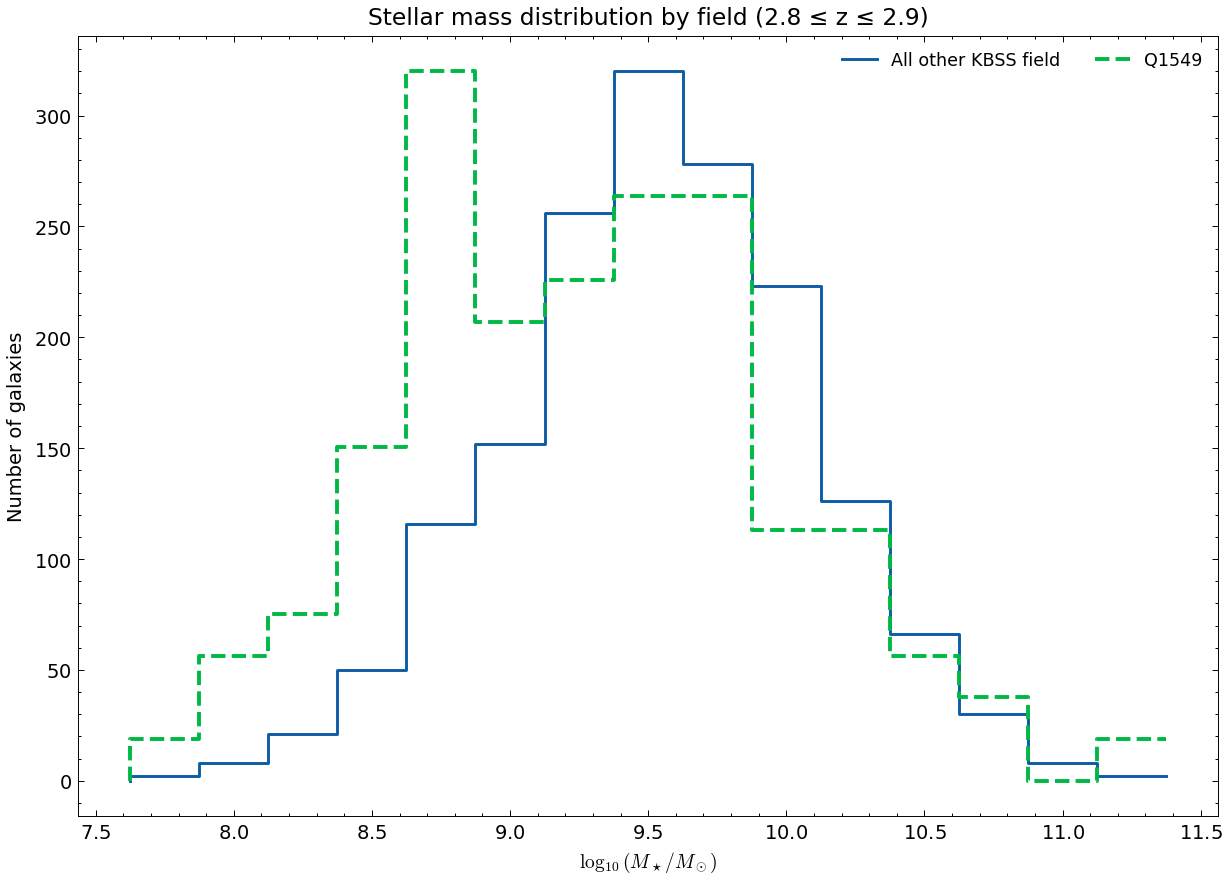

,field,N_in_range
0,Q0100,154
1,Q0105,121
2,Q0142,123
3,Q0207,120
4,Q0256,51
5,Q0449,117
6,Q0821,116
7,Q0933,63
8,Q1009,142
9,Q1217,79


,field,KS_stat,p_value
0,Q0100,0.235639,1.598726e-03
1,Q0105,0.373739,1.630565e-07
2,Q0142,0.291253,9.597984e-05
3,Q0207,0.245470,1.824053e-03
4,Q0256,0.173265,2.201205e-01
5,Q0449,0.317960,1.810721e-05
6,Q0821,0.297009,8.622182e-05
7,Q0933,0.196581,8.137080e-02
8,Q1009,0.191434,2.073856e-02
9,Q1217,0.220545,2.065004e-02


[INFO] Wrote KS results to field_compare_auto_ks_tests.csv
[INFO] Wrote: field_compare_auto_hist_compare.png, field_compare_auto_hist_counts.csv, field_compare_auto_merged_all.csv, field_compare_auto_selected_all.csv


<Figure size 490x367.5 with 0 Axes>

In [110]:
# ================================================================
# Jupyter-Lab: Auto-discover fields & files (no per-field typing)
# ================================================================

# ---------- Configuration (EDIT as needed) ----------
SED_BASE = "/disk/bifrost/yuanze/KBSS/sedfit_master/allfields"   # parent folder containing subdirs like q1549, q0100, ...
CAT_BASE = "/disk/bifrost/yuanze/KBSS/cats"            # folder containing catalogs

# Default filename patterns (used first), then we fall back to globs if not found
#   Example: sed  -> /.../sedfit_master/q1549/summary_csf_agegt50.dat
#            cat  -> /.../cats/z.q1549_kbss.cat
SED_FILENAME_PATTERN = "summary_csf_agegt50.dat"
CAT_FILENAME_PATTERN = "z.{field_lower}_kbss.cat"

# Select fields: set to [] or None to include **all** discovered fields
FIELDS_INCLUDE = None    # e.g. ["Q1549","Q0100"] to restrict; None for all

primary_field = "Q1549"  # highlighted in plot if present
normalize = False        # True -> compare shapes (fraction per field)
zminprimary, zmaxprimary = 2.8, 2.9    # inclusive redshift window

zminref,zmaxref = 2.0, 3.2
# Mass histogram bins in log10(M*)
bin_start, bin_stop, bin_step = 7.5, 11.5, 0.25

# Which token in SED line is stellar mass? (0-based)
# Example lines:  ID 0 0.11 63 17 1.0797312e+09 1.49  -> mass_col_index = 5
mass_col_index = 5

out_prefix = "field_compare_auto"


# ---------- Imports ----------
import os, re, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple, Optional

%matplotlib inline

# Optional: astropy for robust ASCII reading
try:
    from astropy.table import Table
    ASTROPY_OK = True
except Exception:
    ASTROPY_OK = False

# Optional: SciPy KS tests
try:
    from scipy.stats import ks_2samp
    SCIPY_OK = True
except Exception:
    SCIPY_OK = False


# ---------- File discovery ----------
def discover_fields_and_paths(
    sed_base: str,
    cat_base: str,
    sed_filename_pattern: str,
    cat_filename_pattern: str,
    include_fields: Optional[List[str]] = None
) -> Dict[str, Dict[str, str]]:
    """
    Returns a dict:
      { FIELD: {'sed': <path>, 'cat': <path>} }
    Discovers FIELDs primarily from subdirs under sed_base (qxxxx).
    Tries patterns first; if missing, falls back to globbing reasonable alternatives.
    """
    results = {}

    # 1) Find candidate field folder names under sed_base, e.g., "q1549", "q0100", ...
    sed_dirs = sorted([d for d in glob.glob(os.path.join(sed_base, "q*")) if os.path.isdir(d)])

    # Helper: normalize "q1549" -> "Q1549"
    def folder_to_field(folder_name: str) -> str:
        bn = os.path.basename(folder_name).strip()
        return bn.upper()  # "q1549" -> "Q1549"; "Q0100" stays "Q0100"

    # For catalog pattern fill-ins we also want lower-case, e.g., "q1549"
    def field_to_lower(field: str) -> str:
        return field.lower()

    # 2) Iterate discovered field folders
    for sdir in sed_dirs:
        field = folder_to_field(sdir)
        if include_fields and field not in include_fields:
            continue

        field_lower = field_to_lower(field)  # e.g., Q1549 -> q1549

        # -- Build default expected paths
        sed_path = os.path.join(sdir, sed_filename_pattern)
        cat_path = os.path.join(cat_base, cat_filename_pattern.format(field_lower=field_lower))

        # -- SED fallback: if not found, try common globs (be conservative)
        if not os.path.exists(sed_path):
            candidates = []
            candidates += glob.glob(os.path.join(sdir, "summary*.dat"))
            candidates += glob.glob(os.path.join(sdir, "*summary*.dat"))
            sed_path = candidates[0] if candidates else sed_path  # keep original if nothing

        # -- CAT fallback: if not found, try common alternatives
        if not os.path.exists(cat_path):
            candidates = []
            candidates += glob.glob(os.path.join(cat_base, f"z.{field_lower}_*.cat"))
            candidates += glob.glob(os.path.join(cat_base, f"{field_lower}*.cat"))
            candidates += glob.glob(os.path.join(cat_base, f"*{field_lower}*.cat"))
            if candidates:
                # try to pick the one ending with _kbss.cat if present
                kbss = [c for c in candidates if c.endswith("_kbss.cat")]
                cat_path = (kbss[0] if kbss else candidates[0])

        # Only keep field if both files exist
        if os.path.exists(sed_path) and os.path.exists(cat_path):
            results[field] = {"sed": sed_path, "cat": cat_path}
        else:
            missing = []
            if not os.path.exists(sed_path): missing.append("SED")
            if not os.path.exists(cat_path): missing.append("CAT")
            print(f"[WARN] Skipping {field}: Missing {', '.join(missing)}")

    # If include_fields specified, warn about any not found
    if include_fields:
        for f in include_fields:
            if f not in results:
                print(f"[WARN] Requested field '{f}' not discovered with existing files.")

    return results


# ---------- Parsers & utilities ----------
def read_sed_results(path: str, mass_col_index: int = 5, sfr_col_index: int = 4) -> pd.DataFrame:
    rows = []
    with open(path, 'r') as f:
        for line in f:
            s = line.strip()
            if not s:
                continue
            parts = re.split(r"\s+", s)
            if len(parts) <= mass_col_index:
                continue
            sid = parts[0].strip()
            try:
                mstar = float(parts[mass_col_index])
                sfr=float(parts[sfr_col_index])
            except Exception:
                nums = [p for p in parts[1:] if re.match(r"^[+-]?\d+(\.\d+)?(e[+-]?\d+)?$", p, re.I)]
                mstar = float(nums[-1]) if nums else np.nan
            rows.append({"SED_ID": sid, "stellar_mass": mstar, "SFR":sfr})
    sed_df = pd.DataFrame(rows)
    sed_df["SED_ID"] = sed_df["SED_ID"].str.strip()
    return sed_df


def _to_float_or_nan(x):
    try:
        if isinstance(x, str) and x.strip().lower() in {"na", "n/a", "nan", ""}:
            return np.nan
        return float(x)
    except Exception:
        return np.nan


def read_catalog(path: str) -> pd.DataFrame:
    """
    Robust reader for KBSS-style whitespace ASCII catalogs with a single header line
    and a quoted comments column.
    Tries astropy (explicit format, no guessing) then falls back to pandas.
    """
    # Try astropy with explicit settings
    try:
        from astropy.io import ascii
        tab = ascii.read(
            path,
            format="basic",
            delimiter=" ",
            guess=False,
            fast_reader=False,
            quotechar='"'
        )
        df = tab.to_pandas()
    except Exception:
        # Fallback: pandas is excellent for this layout
        import pandas as pd
        df = pd.read_csv(
            path,
            sep=r"\s+",
            engine="python",
            quotechar='"',
            comment=None,
            skip_blank_lines=True
        )

    # Normalize column names
    df.columns = [c.strip() for c in df.columns]
    # Harmonize variants for downstream code
    for old, new in {"Name": "NAME", "Field": "FIELD"}.items():
        if old in df.columns and new not in df.columns:
            df.rename(columns={old: new}, inplace=True)

    # Build FULL_ID if possible
    if "FIELD" in df.columns and "NAME" in df.columns:
        df["FIELD"] = df["FIELD"].astype(str).str.strip()
        df["NAME"]  = df["NAME"].astype(str).str.strip()
        df["FULL_ID"] = df["FIELD"] + "-" + df["NAME"]
    return df


def choose_best_redshift(row: pd.Series, priority=("zneb", "zabs", "zlya")) -> float:
    for zc in priority:
        if zc in row and pd.notna(row[zc]):
            z = float(row[zc])
            if z > 0:
                return z
    return np.nan


def merge_and_select_one_field(
    field_name: str,
    sed_file: str,
    catalog_file: str,
    zmin: float,
    zmax: float,
    mass_col_index: int = 5,
    Remove_NB: bool = False,
    NB_only: bool = False,
    NBcat_name: str = None
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    sed_df = read_sed_results(sed_file, mass_col_index=mass_col_index)
    cat_df_part = read_catalog(catalog_file)
    if NBcat_name is not None:
        NBcat = read_catalog(NBcat_name)
        cat_df = pd.concat([cat_df_part,NBcat], ignore_index=True)
    else:
        cat_df = cat_df_part
    merged = sed_df.merge(cat_df, right_on="FULL_ID", left_on="SED_ID", how="left")
    merged["z_best"] = merged.apply(choose_best_redshift, axis=1)
    #naname=merged["NAME"].isnull()
    merged["NAME"]=merged["SED_ID"].str.rsplit("-", n=1).str[-1]
    if Remove_NB:
        merged=merged[~merged["NAME"].astype(str).str.contains("NB", case=False, na=False)]
    elif NB_only:
        merged=merged[merged["NAME"].astype(str).str.contains("NB", case=False, na=False)]
    #try:
    selected = merged[
        merged["z_best"].between(zmin, zmax, inclusive="both")
        & np.isfinite(merged["stellar_mass"])
        & (merged["stellar_mass"] > 0) #& (merged["Rs"] > 25.0)
    ].copy()
    #except:
    #    print("exception when Rs=",merged["Rs"],"at",merged["NAME"])
    return merged, selected


def field_logM(df: pd.DataFrame, field_name: str) -> np.ndarray:
    f = df[df["FIELD"].astype(str).str.strip() == field_name]
    if f.empty:
        return np.array([])
    return np.log10(f["stellar_mass"].values)


def compute_histograms_by_field(
    df_selected_all: pd.DataFrame,
    fields: List[str],
    bin_edges: np.ndarray,
    normalize: bool = False
) -> Dict[str, np.ndarray]:
    hists = {}
    for fld in fields:
        x = field_logM(df_selected_all, fld)
        counts, _ = np.histogram(x, bins=bin_edges)
        if normalize and counts.sum() > 0:
            counts = counts / counts.sum()
        hists[fld] = counts.astype(float)
    return hists


def save_hist_table(hists: Dict[str, np.ndarray], bin_edges: np.ndarray, out_csv: str) -> None:
    centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    df = pd.DataFrame({"logM_bin_center": centers})
    for fld, arr in hists.items():
        df[fld] = arr
    df.to_csv(out_csv, index=False)


def plot_hist_comparison(
    hists: Dict[str, np.ndarray],
    bin_edges: np.ndarray,
    primary_field: str,
    out_png: str,
    title: str,
    ylabel: str = "Number of galaxies",
    renorm: bool = False,
    figsize=(9.0, 6.5)
) -> None:
    centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    plt.figure(figsize=figsize)
    secondary = [k for k in hists.keys() if k != primary_field]
    #= [primary_field] + [k for k in hists.keys() if k != primary_field]
    y=0
    for k in secondary:
        y += hists[k]
    y_prim=hists[primary_field]
     #   lw = 2.5 if k == primary_field else 1.5
    #    lab = f"{k} (primary)" if k == primary_field else k
    ymax=np.max(y)
    yprim_max=np.max(y_prim)
    if renorm:
        renorm=ymax/yprim_max
    else:
        renorm=1
    plt.step(centers, y, linewidth=1.5, label="All other KBSS field")
    plt.step(centers,y_prim*renorm,linewidth=2.0,ls="--",label=primary_field)
    plt.xlabel(r"$\log_{10}(M_\star/M_\odot)$")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(ncols=2, fontsize=9)
    plt.tight_layout()
    plt.show()
    plt.savefig(out_png, dpi=180)


def ks_compare(primary_vals: np.ndarray, other_vals: np.ndarray):
    if not SCIPY_OK or primary_vals.size == 0 or other_vals.size == 0:
        return np.nan, np.nan
    stat, pval = ks_2samp(primary_vals, other_vals, alternative="two-sided", mode="auto")
    return float(stat), float(pval)


# ---------- Discover + Run ----------
found = discover_fields_and_paths(
    sed_base=SED_BASE,
    cat_base=CAT_BASE,
    sed_filename_pattern=SED_FILENAME_PATTERN,
    cat_filename_pattern=CAT_FILENAME_PATTERN,
    include_fields=FIELDS_INCLUDE
)
if not found:
    raise RuntimeError("No fields discovered. Check base paths & patterns.")

print("[INFO] Discovered fields:")
for f, p in found.items():
    print(f"  {f}: SED='{p['sed']}', CAT='{p['cat']}'")

fields_to_use = list(found.keys())
if primary_field not in fields_to_use:
    primary_field = fields_to_use[0]  # fallback if not present
    print(f"[WARN] Primary field not discovered; using '{primary_field}' as primary.")

merged_all, selected_all = [], []
for fld in fields_to_use:
    sed = found[fld]["sed"]
    cat = found[fld]["cat"]
    if fld != primary_field:
        zmin,zmax=zminref,zmaxref
        NBcat_name=None
        NB_only=False
        Remove_NB=False
    else:
        zmin,zmax=zminprimary,zmaxprimary
        NBcat_name=CAT_BASE+"/nbcats/z.q1549.nb4670"
        NB_only=False
        Remove_NB=False
    merged, selected = merge_and_select_one_field(
        field_name=fld, sed_file=sed, catalog_file=cat,
        zmin=zmin, zmax=zmax, mass_col_index=mass_col_index, Remove_NB=Remove_NB,NB_only=NB_only,NBcat_name=NBcat_name
    )
    print(f"[INFO] {fld}: merged={len(merged)}, selected (z∈[{zmin},{zmax}])={len(selected)}")
    merged_all.append(merged)
    selected_all.append(selected)

df_merged_all   = pd.concat(merged_all, ignore_index=True)
df_selected_all = pd.concat(selected_all, ignore_index=True) if selected_all else df_merged_all.iloc[0:0].copy()

print(f"[INFO] Total merged rows (all fields): {len(df_merged_all)}")
print(f"[INFO] Total selected rows (all fields): {len(df_selected_all)}")

# Prepare bins & histograms
bin_edges = np.arange(bin_start, bin_stop + 1e-12, bin_step)
hists = compute_histograms_by_field(
    df_selected_all=df_selected_all,
    fields=fields_to_use,
    bin_edges=bin_edges,
    normalize=normalize
)

# Save outputs
os.makedirs(os.path.dirname(out_prefix) if os.path.dirname(out_prefix) else ".", exist_ok=True)
save_hist_table(hists, bin_edges, f"{out_prefix}_hist_counts.csv")

title = (f"Stellar mass distribution by field ({zminprimary} ≤ z ≤ {zmaxprimary})"
         f"{' — normalized' if normalize else ''}")
ylabel = "Fraction of galaxies" if normalize else "Number of galaxies"
plot_hist_comparison(
    hists=hists,
    bin_edges=bin_edges,
    primary_field=primary_field,
    out_png=f"{out_prefix}_hist_compare.png",
    title=title,
    renorm=True,
    ylabel=ylabel
)

# Totals & KS
totals = {fld: int(hists[fld].sum()) for fld in fields_to_use}
display(pd.DataFrame({"field": list(totals.keys()), "N_in_range": list(totals.values())}))

p_rows = []
x0 = field_logM(df_selected_all, primary_field)
for fld in fields_to_use:
    if fld == primary_field:
        continue
    x1 = field_logM(df_selected_all, fld)
    stat, pval = ks_compare(x0, x1)
    p_rows.append({"field": fld, "KS_stat": stat, "p_value": pval})
if p_rows:
    ks_df = pd.DataFrame(p_rows)
    display(ks_df)
    if SCIPY_OK:
        ks_df.to_csv(f"{out_prefix}_ks_tests.csv", index=False)
        print(f"[INFO] Wrote KS results to {out_prefix}_ks_tests.csv")
    else:
        print("[INFO] SciPy not available; KS results not saved.")

# Save merged/selected tables for inspection
df_merged_all.to_csv(f"{out_prefix}_merged_all.csv", index=False)
df_selected_all.to_csv(f"{out_prefix}_selected_all.csv", index=False)
print(f"[INFO] Wrote: {out_prefix}_hist_compare.png, {out_prefix}_hist_counts.csv, "
      f"{out_prefix}_merged_all.csv, {out_prefix}_selected_all.csv")


In [609]:
ks_2samp(hists["Q1549"],hists["Q1603"])

KstestResult(statistic=0.25, pvalue=0.7164116566837258, statistic_location=11.0, statistic_sign=1)

In [607]:
hists["Q1549"]

array([0., 1., 2., 3., 6., 7., 8., 4., 4., 7., 2., 3., 2., 1., 0., 1.])

# Now pair things up between MSA catalog and SED results
We also need a few functions from previous section

In [151]:
# Cell 1: imports & helpers
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 140

def add_catalog_id(df: pd.DataFrame, id_col: str = "ID") -> pd.DataFrame:
    """
    Ensure an integer ID column that is (index + 1).
    If the catalog already has an ID column, it will be overwritten
    to enforce the 'index+1' rule you specified.
    """
    out = df.reset_index(drop=True).copy()
    out[id_col] = np.arange(1, len(out) + 1, dtype=int)
    return out

def safe_read_csv(path, **kwargs):
    try:
        return pd.read_csv(path, **kwargs)
    except FileNotFoundError:
        print(f"[WARN] Missing file: {path}")
        return None

def log10_safe(x: pd.Series) -> pd.Series:
    """Return log10(x) with NaN for non-positive or non-numeric values, preserving index."""
    s = pd.to_numeric(x, errors="coerce")
    s = s.where(s > 0)             # non-positive → NaN
    return np.log10(s)             # returns a Series because s is a Series

def nice_hist(series, bins=30, title="", xlabel="", ylabel="Count",**kwarg):
    s = pd.to_numeric(series, errors="coerce").dropna()
    fig = plt.figure()
    plt.hist(s, bins=bins,**kwarg)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    ax=plt.gca()
    #plt.show()
    return fig,ax


In [152]:
folder="/disk/bifrost/yuanze/KBSS/JWST_cycle5/"
targetlist_MSA = pd.read_csv(
            folder+"targets_merged_with_weights.csv",
            sep=r",",
            engine="python",
            quotechar='"',
            #comment="#",
            skip_blank_lines=True
        )
fld="Q1549"
sed = found[fld]["sed"]
cat = found[fld]["cat"]
#if fld != primary_field:
#    zmin,zmax=zminref,zmaxref
#else:
zmin,zmax=zminprimary,zmaxprimary
NBcat_name=CAT_BASE+"/nbcats/z.q1549.nb4670"
merged, selected = merge_and_select_one_field(
    field_name=fld, sed_file=sed, catalog_file=cat,
    zmin=zmin, zmax=zmax, mass_col_index=mass_col_index, Remove_NB=False,NB_only=False,NBcat_name=NBcat_name)
MSA_merged=targetlist_MSA.merge(merged, left_on="name", right_on="NAME", how="left")
MSA_merged.to_csv(f"{folder}MSA_merged_catalog.csv", index=False)

In [154]:
MSA_merged[MSA_merged["SED_ID"]=="Q1549-GNB5571"]["z_guess"]

174    2.7137
Name: z_guess, dtype: float64

In [155]:
# Load merged target catalog
merged = pd.read_csv(f"{folder}MSA_merged_catalog.csv")
merged = add_catalog_id(merged, id_col="ID")  # guarantees ID = index+1
print(f"Merged catalog rows: {len(merged)}")
merged.head(3)

file_map = {
    "c1e1n1": os.path.join(folder, "selected", "obs4-exp1-c1e1n1-G235M-F170LP.csv"),
    "c2e1n1": os.path.join(folder, "selected", "obs4-exp3-c2e1n1-G235M-F170LP.csv"),
    "c3e1n1": os.path.join(folder, "selected", "obs4-exp5-c3e1n1-G235M-F170LP.csv"),
    "c4e1n1": os.path.join(folder, "selected", "obs4-exp7-c4e1n1-G235M-F170LP.csv"),
}

selected_list = []
for cfg, path in file_map.items():
    df = safe_read_csv(path, sep=",", engine="python", quotechar='"', skip_blank_lines=True)
    if df is not None and len(df):
        df = df.copy()
        df["config"] = cfg
        selected_list.append(df)
if not selected_list:
    raise RuntimeError("No selected config tables could be loaded. Check your paths.")

selected_all = pd.concat(selected_list, ignore_index=True)
print(f"Selected total rows across configs: {len(selected_all)}")
selected_all.head(3)

Merged catalog rows: 1368
Selected total rows across configs: 116


,ID,Source RA (Degrees),Source Dec (Degrees),Source Type,Source MSA Disp (meters),Source MSA Spat (meters),Aperture PA (Degrees),Fiducial RA (Degrees),Fiducial Dec (Degrees),V2 (arcsec),...,Quadrant,Column (Disp),Row (Spat),Offset (x),Offset (y),NRS1 Min Wave,NRS1 Max Wave,NRS2 Min Wave,NRS2 Max Wave,config
0,1,237.96474,19.18521,Primary,0.010460,-0.028762,258.0058,237.988044,19.182285,408.3247,...,3,57,65,0.355,0.435,-1.0,2.604993,2.769045,-2.0,c1e1n1
1,2,237.97402,19.18614,Primary,0.009198,-0.016742,258.0058,237.988044,19.182285,389.9060,...,3,45,124,0.307,0.488,-1.0,2.586731,2.750969,-2.0,c1e1n1
2,3,237.96366,19.18492,Primary,0.010357,-0.030209,258.0058,237.988044,19.182285,411.0382,...,3,56,58,0.374,0.328,-1.0,2.600419,2.764447,-2.0,c1e1n1


In [157]:
# Cell 4: join by ID
# Assumes the selected tables have an "ID" column that matches merged.ID (= index+1 of merged)
if "ID" not in selected_all.columns:
    raise ValueError("The selected_* CSVs must contain an 'ID' column.")

paired = selected_all.merge(
    merged,
    on="ID",
    how="left",
    suffixes=("", "_merged")
)

# Basic QC: list any IDs that didn't match
unmatched = paired[paired["group"].isna()]  # 'group' comes from merged catalog sample row you pasted
if len(unmatched):
    print("[WARN] Unmatched IDs (not found in merged catalog):", sorted(unmatched["ID"].unique()))
else:
    print("All IDs in selected tables matched the merged catalog.")

# Peek
paired_cols_to_show = [
    "config", "ID", " Source RA (Degrees)", " Source Dec (Degrees)", " Source Type",
    "group", "name", "stellar_mass", "SFR", "z_best","z_guess"
]
paired[paired_cols_to_show].head(30)


All IDs in selected tables matched the merged catalog.


,config,ID,Source RA (Degrees),Source Dec (Degrees),Source Type,group,name,stellar_mass,SFR,z_best,z_guess
0,c1e1n1,1,237.964740,19.185210,Primary,Primary,MD10,8.872631e+09,140.0,2.8513,2.8491
1,c1e1n1,2,237.974020,19.186140,Primary,Primary,MD17,4.960564e+10,24.0,2.8430,2.8450
2,c1e1n1,3,237.963660,19.184920,Primary,Primary,M15,7.324262e+10,36.0,2.8450,2.8411
3,c1e1n1,4,237.992000,19.207278,Primary,Primary,GNB4950b,NaN,NaN,NaN,2.8516
4,c1e1n1,31,237.957040,19.182780,Primary,Primary,C12,4.456804e+09,5.0,2.8352,2.8372
5,c1e1n1,39,237.965460,19.171030,Primary,Primary,D11,7.176793e+09,22.0,2.8370,2.8390
6,c1e1n1,53,238.014167,19.167028,Primary,Primary,LAB43,NaN,NaN,NaN,NaN
7,c1e1n1,56,238.009129,19.180102,Primary,Primary,SMGL2019-9,NaN,NaN,NaN,2.8500
8,c1e1n1,106,237.970250,19.194703,Primary,Primary,GNB2512,1.648489e+08,3.0,2.8387,2.8387
9,c1e1n1,111,237.971167,19.195022,Primary,Primary,GNB2659,2.341881e+09,1.0,2.8391,2.8391


In [158]:
paired.to_csv(f"{folder}MSA_paired_catalog.csv", index=False)

In [159]:
# Cell 6: summary stats
def summarize(df, by="config"):
    cols = ["stellar_mass", "SFR", "z_guess"]
    agg = {
        "stellar_mass": ["count", "median", "mean", "min", "max"],
        "SFR": ["median", "mean", "min", "max"],
        "z_guess": ["median", "mean", "min", "max"],
    }
    out = (df
           .groupby(by, dropna=False)[cols]
           .agg(agg))
    return out

summary_by_config = summarize(paired, by="config")
summary_by_group  = summarize(paired, by="group")  # e.g., Primary vs Filler if present

summary_by_group


stellar_mass                                                         \
               count        median          mean          min           max   
group                                                                         
Filler            18  3.929047e+09  7.144458e+09  775888190.0  3.022282e+10   
Primary           34  2.715270e+09  3.370918e+10  164848930.0  5.770841e+11   

           SFR                        z_guess                            
        median       mean  min    max  median      mean     min     max  
group                                                                    
Filler    12.5  12.833333  4.0   28.0  2.0942  2.161744  1.5975  3.2202  
Primary    6.0  25.882353  0.0  289.0  2.8457  2.841575  2.7137  2.9152

In [127]:
paired

,ID,Source RA (Degrees),Source Dec (Degrees),Source Type,Source MSA Disp (meters),Source MSA Spat (meters),Aperture PA (Degrees),Fiducial RA (Degrees),Fiducial Dec (Degrees),V2 (arcsec),...,zlya,zabs,zneb,type,comments_y,FULL_ID,NBmag,NBcol,Comments,z_best
0,1,237.964740,19.185210,Primary,0.010460,-0.028762,258.0058,237.988044,19.182285,408.3247,...,2.853,-2.0000,2.8513,QSO,also GNB2267; on QSO-W kcwi cube; zneb from [O...,Q1549-MD10,NaN,NaN,NaN,2.8513
1,2,237.974020,19.186140,Primary,0.009198,-0.016742,258.0058,237.988044,19.182285,389.9060,...,2.848,2.8430,-1.0000,QSO,"on kcwi QSO-E kcwi cube;also NB2079; nz; m3,m6...",Q1549-MD17,NaN,NaN,NaN,2.8430
2,3,237.963660,19.184920,Primary,0.010357,-0.030209,258.0058,237.988044,19.182285,411.0382,...,2.845,-2.0000,-1.0000,AGN,aka NB1614 on mask N1; appears to have broad C...,Q1549-M15,NaN,NaN,NaN,2.8450
3,4,237.992000,19.207278,Primary,0.033500,0.012373,258.0058,237.988044,19.182285,293.5863,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,31,237.957040,19.182780,Primary,0.009228,-0.039159,258.0058,237.988044,19.182285,428.8071,...,-2.000,2.8352,-1.0000,GAL,nz; m3; possible addl z=2.158,Q1549-C12,NaN,NaN,NaN,2.8352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,636,237.980375,19.143361,Filler,-0.027033,0.025755,257.9957,237.957090,19.158179,386.1235,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
112,651,237.975833,19.147325,Filler,-0.020260,0.021019,257.9957,237.957090,19.158179,381.2833,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
113,682,237.935042,19.145575,Filler,-0.011219,-0.031583,257.9957,237.957090,19.158179,454.9212,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114,934,237.923313,19.172086,Contaminant,0.028388,-0.038801,257.9957,237.957090,19.158179,391.3663,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [160]:
# Cell 8: examples of filtering
# Only Primary group targets:
selected_1 = paired[(paired["config"] == "c1e1n1") &(paired["type"] != "QSO")&(paired["type"] != "AGN")].copy()
selected_2 = paired[(paired["config"] == "c2e1n1")].copy()
selected_3 = paired[(paired["config"] == "c3e1n1")].copy()
selected_4 = paired[(paired["config"] == "c4e1n1")].copy()
allconf=[selected_1,selected_2,selected_3,selected_4]
# High-mass, high-SFR subset example:
#hm_hs = paired[(log10_safe(paired["stellar_mass"]) > 10.0) & (paired["SFR"] > 50)].copy()

#len(primary), len(hm_hs)


In [149]:
allconf[1]["comments_x"]

30                        2.86873 CO detection
31        2.85203 in HS1549 tail also LAE 1617
32                    2.8524 inside QSO nebula
33                                       2.851
34                                        2.83
35    2.8290 LyC leaker lae7832 in Mostardi+13
36                                      2.8547
37                                     2.84052
38                                     2.84578
39                                     2.79766
40                                     2.76574
41                                     2.86042
42                                      2.8495
43                                      2.8680
44                                     2.71367
45                                     2.84562
46                                      2.8414
47                                      2.8388
48                                      2.8633
49                                      2.8466
50                                         NaN
51           

/tmp/ipykernel_1587442/2022940965.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap_name)
/tmp/ipykernel_1587442/2022940965.py:15: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  out["ad"]  = stats.anderson_ksamp([x_true, x_obs])   # smaller statistic is better; critical values in result
/tmp/ipykernel_1587442/2022940965.py:15: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  out["ad"]  = stats.anderson_ksamp([x_true, x_obs])   # smaller statistic is better; critical values in result


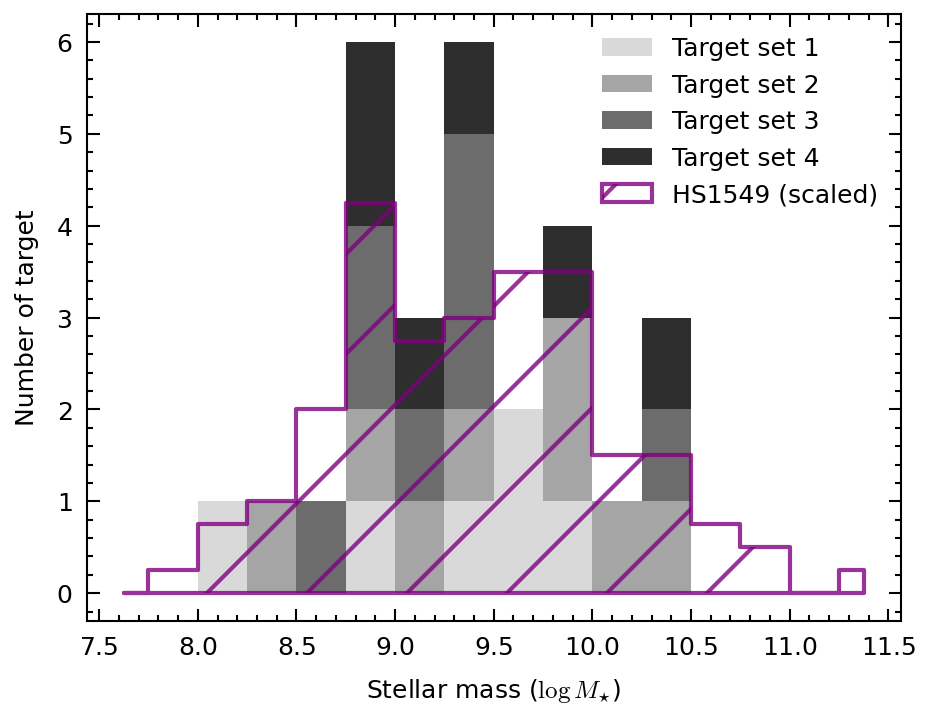

In [162]:
import scienceplots
from matplotlib import cm
from scipy import stats
plt.style.use(["science",'no-latex'])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":6,
"legend.fancybox":True})
def one_d_tests(x_true, x_obs):
    x_true = np.asarray(x_true); x_obs = np.asarray(x_obs)
    x_true = x_true[np.isfinite(x_true)]; x_obs = x_obs[np.isfinite(x_obs)]
    out = {}
    out["ks"]  = stats.ks_2samp(x_true, x_obs, alternative="two-sided", method="asymp")
    out["ad"]  = stats.anderson_ksamp([x_true, x_obs])   # smaller statistic is better; critical values in result
    out["cvm"] = stats.cramervonmises_2samp(x_true, x_obs)
    # Energy distance (works multivariate too if you stack columns later)
    out["energy"] = stats.energy_distance(x_true, x_obs)
    return out
def make_grays(labels, cmap_name="Greys", low=0.25, high=0.85):
    """
    Map each unique label to a gray color from a colormap.
    low/high keep you away from pure white/black so points/lines stay visible.
    """
    uniq = list(dict.fromkeys(labels))              # preserve order, drop dups
    n = len(uniq)
    if n == 1:
        vals = np.array([(low + high) / 2.0])
    else:
        vals = np.linspace(low, high, n)
    cmap = cm.get_cmap(cmap_name)
    return {lbl: cmap(v) for lbl, v in zip(uniq, vals)}

gray_map = make_grays(list(paired["config"]), cmap_name="Greys", low=0.25, high=0.85)

# Cell 7a: stellar mass (log10) histogram across all selected targets

bin_start,bin_stop,bin_step=7.5,11.5,0.25
bin_edges = np.arange(bin_start, bin_stop + 1e-12, bin_step)


logM = log10_safe(paired["stellar_mass"])
s = pd.to_numeric(logM, errors="coerce").dropna()
counts, _ = np.histogram(s, bins=bin_edges)

centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

fig1=plt.figure(dpi=300)
#plt.step(centers, counts, linewidth=1.5,where="mid", label="All observed targets")
ax1=plt.gca()
#fig1,ax1=nice_hist(logM, bins=30, title="Selected targets: log10( Stellar Mass / Msun )",
#          xlabel="log10(M*)",alpha=0.2)
totalcounts=0
stats_out=[]
counts_all=[]
for ind,conf in enumerate(allconf):
    conf=conf[(conf["z_guess"] < 2.9)&(conf["z_guess"] > 2.8)]#&(conf["name"].str.contains("NB"))]
    #print(conf["name"],conf["stellar_mass"])
    logMconf = log10_safe(conf["stellar_mass"])
    sconf1 = pd.to_numeric(logMconf, errors="coerce").dropna()
    counts, _ = np.histogram(sconf1, bins=bin_edges)
    counts_all.append(counts)
    #statsks_2samp(,hists["Q1603"])
    ax1.fill_between(centers,totalcounts,totalcounts+counts,step="mid",color=gray_map[conf["config"].to_list()[0]],edgecolor="none", label=f"Target set {ind+1}")
    totalcounts+=counts
    #stat, pval = ks_2samp(hists["Q1549"], totalcounts, alternative="two-sided", mode="auto")
    stats_out.append(one_d_tests(hists["Q1549"], totalcounts))
    #ax1.step(centers, totalcounts,color=f"C{ind+1}", linewidth=1.5, label=f"Config.{ind+1}")
ax1.fill_between(centers,0,hists["Q1549"]/4,step="mid",color="none",hatch="/",alpha=0.8,edgecolor="Purple", label=f"HS1549 (scaled)")

ax1.set_xlabel("Stellar mass ($\log M_{\star}$)")
ax1.set_ylabel("Number of target")
ax1.legend()
plt.show()
#fig1.savefig("/disk/bifrost/yuanze/KBSS/JWST_cycle5/Mstar_selection.pdf")
# Cell 7b: SFR histogram (linear)
#fig2,ax2=nice_hist(paired["SFR"], bins=30, title="Selected targets: SFR distribution", xlabel="SFR [Msun/yr]")

# Cell 7c: z histogram (linear)
#fig3,ax3=nice_hist(paired["z_guess"], bins=30, title="Selected targets: redshift distribution", xlabel="Redshift")


    #sconf3 = pd.to_numeric(paired["z_guess"], errors="coerce").dropna()
    

In [124]:
conf["config"]

Series([], Name: config, dtype: object)

Text(0.5, 0, 'Number of configurations')

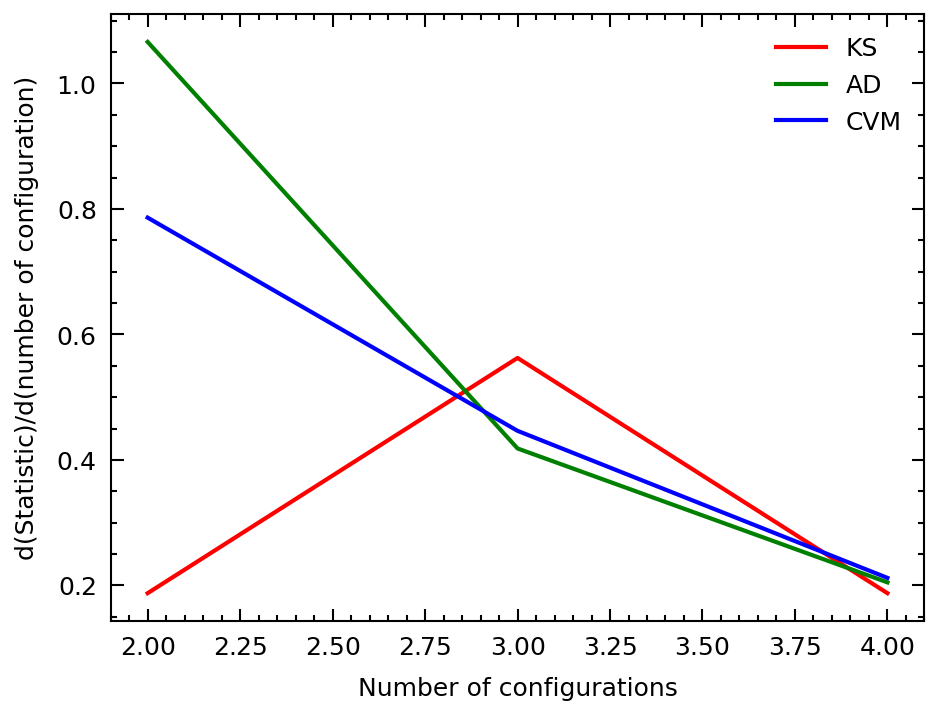

In [747]:
ks=[]
ad=[]
cvm=[]
plt.figure(dpi=300)
for ind,out in enumerate(stats_out):
    ks.append(out['ks'].statistic)
    ad.append(out['ad'].statistic)
    cvm.append(out['cvm'].statistic)
    #plt.scatter(ind+1,out['ks'].statistic,color="r")
    #plt.scatter(ind+1,out['ad'].statistic,color="g")
plt.plot([2,3,4],-np.diff(ks)*3,color="r",label="KS")
plt.plot([2,3,4],-np.diff(ad)/8,color="g",label="AD")
plt.plot([2,3,4],-np.diff(cvm),color="b",label="CVM")
plt.ylabel("d(Statistic)/d(number of configuration)")
plt.legend()
plt.xlabel("Number of configurations")

In [751]:
cumulative_counts=[np.sum(count[:5]) for count in counts_all]
cumulative_rate=[np.sum(count[:5])/np.sum(count) for count in counts_all]

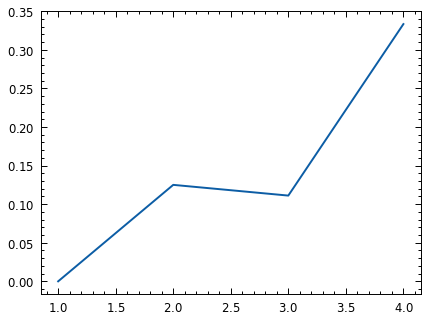

In [752]:
plt.plot([1,2,3,4],cumulative_rate)

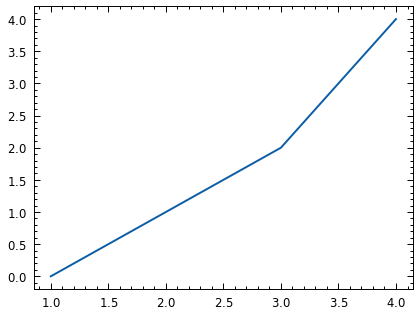

In [753]:
plt.plot([1,2,3,4],np.cumsum(cumulative_counts))

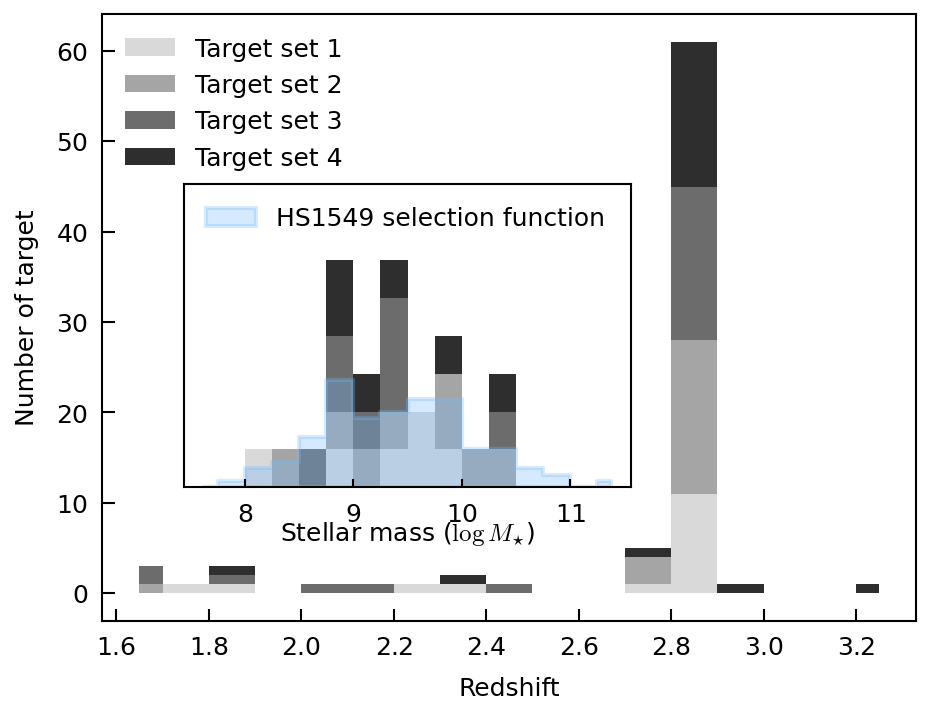

In [313]:
plt.style.use(["science",'no-latex'])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":6,
"legend.fancybox":True})


bin_start,bin_stop,bin_step=1.6,3.3,0.1
bin_edges = np.arange(bin_start, bin_stop + 1e-12, bin_step)


#logM = log10_safe(paired["stellar_mass"])
s = pd.to_numeric(paired["z_guess"], errors="coerce").dropna()
counts, _ = np.histogram(s, bins=bin_edges)

centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

fig1=plt.figure(dpi=300)
#plt.step(centers, counts, linewidth=1.5,where="mid", label="All observed targets")
ax1=plt.gca()
#fig1,ax1=nice_hist(logM, bins=30, title="Selected targets: log10( Stellar Mass / Msun )",
#          xlabel="log10(M*)",alpha=0.2)
totalcounts=0
for ind,conf in enumerate(allconf):
    #logMconf = log10_safe(conf["stellar_mass"])
    sconf1 = pd.to_numeric(conf["z_guess"], errors="coerce").dropna()
    counts, _ = np.histogram(sconf1, bins=bin_edges)
    ax1.fill_between(centers,totalcounts,totalcounts+counts,step="mid",color=gray_map[conf["config"].to_list()[0]],edgecolor="none", label=f"Target set {ind+1}")
    totalcounts+=counts
    #ax1.step(centers, totalcounts,color=f"C{ind+1}", linewidth=1.5, label=f"Config.{ind+1}")
ax1.set_xlabel("Redshift")
ax1.set_ylabel("Number of target")
ax1.legend(loc="upper left")
#fig1.savefig("/disk/bifrost/yuanze/KBSS/JWST_cycle5/Redshift_selection.pdf")


bin_start,bin_stop,bin_step=7.5,11.5,0.25
bin_edges = np.arange(bin_start, bin_stop + 1e-12, bin_step)


logM = log10_safe(paired["stellar_mass"])
s = pd.to_numeric(logM, errors="coerce").dropna()
counts, _ = np.histogram(s, bins=bin_edges)

centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

#fig1=plt.figure(dpi=300)
#plt.step(centers, counts, linewidth=1.5,where="mid", label="All observed targets")
ax2=ax1.inset_axes([0.1,0.22,0.55,0.5])
#fig1,ax1=nice_hist(logM, bins=30, title="Selected targets: log10( Stellar Mass / Msun )",
#          xlabel="log10(M*)",alpha=0.2)
totalcounts=0
#stats_out=[]
counts_all=[]
for ind,conf in enumerate(allconf):
    conf=conf[(conf["z_guess"] < 2.9)&(conf["z_guess"]>2.8)]#&(conf["name"].str.contains("NB"))]
    #print(conf["name"],conf["stellar_mass"])
    logMconf = log10_safe(conf["stellar_mass"])
    sconf1 = pd.to_numeric(logMconf, errors="coerce").dropna()
    counts, _ = np.histogram(sconf1, bins=bin_edges)
    counts_all.append(counts)
    #statsks_2samp(,hists["Q1603"])
    ax2.fill_between(centers,totalcounts,totalcounts+counts,step="mid",color=gray_map[conf["config"].to_list()[0]],edgecolor="none")#, label=f"Target set {ind+1}")
    totalcounts+=counts
    #stat, pval = ks_2samp(hists["Q1549"], totalcounts, alternative="two-sided", mode="auto")
    #stats_out.append(one_d_tests(hists["Q1549"], totalcounts))
    #ax1.step(centers, totalcounts,color=f"C{ind+1}", linewidth=1.5, label=f"Config.{ind+1}")
ax2.fill_between(centers,0,hists["Q1549"]/6,step="mid",alpha=0.3,color="xkcd:sky blue", label=f"HS1549 selection function")
ax2.set_ylim([0,8])
ax2.tick_params(axis='both', which='minor', length=0)
ax2.tick_params(axis='y', which='major', length=0)
ax2.set_yticklabels("")
#ax2.tick_params(axis='y', left=True, right=False, labelleft=True, labelright=False)
ax2.tick_params(axis='x', bottom=True, top=False, labelbottom=True, labeltop=False,which="major",length=2)

ax1.tick_params(axis='y', left=True, right=False, labelleft=True, labelright=False)
ax1.tick_params(axis='x', bottom=True, top=False, labelbottom=True, labeltop=False)

ax1.tick_params(axis='both', which='minor', length=0)

ax2.set_xlabel("Stellar mass ($\log M_{\star}$)",labelpad=-1.5)
#ax2.set_ylabel("Number of target")
ax2.legend(loc="upper left",labelcolor="k", frameon=False, framealpha=0.7)

fig1.savefig("/disk/bifrost/yuanze/KBSS/JWST_cycle5/selection.pdf")

#plt.show()

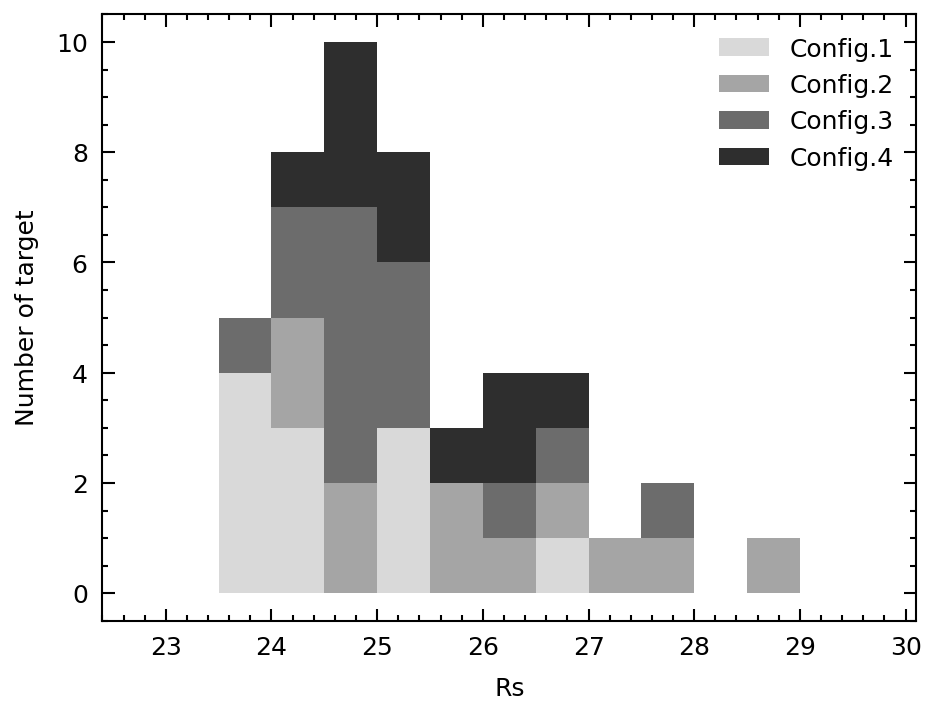

In [766]:
bin_start,bin_stop,bin_step=22.5,30,0.5
bin_edges = np.arange(bin_start, bin_stop + 1e-12, bin_step)


#logM = log10_safe(paired["stellar_mass"])
#s = pd.to_numeric(paired["Rs"], errors="coerce").dropna()
#counts, _ = np.histogram(s, bins=bin_edges)

centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

fig1=plt.figure(dpi=300)
#plt.step(centers, counts, linewidth=1.5,where="mid", label="All observed targets")
ax1=plt.gca()
#fig1,ax1=nice_hist(logM, bins=30, title="Selected targets: log10( Stellar Mass / Msun )",
#          xlabel="log10(M*)",alpha=0.2)
totalcounts=0
for ind,conf in enumerate(allconf):
    #logMconf = log10_safe(conf["stellar_mass"])
    #conf[conf["Rs"]]
    sconf1 = pd.to_numeric(conf["Rs"], errors="coerce")
    sconf2 = pd.to_numeric(conf["NBmag"], errors="coerce")
    sconf3 = pd.to_numeric(conf["NBcol"], errors="coerce")
    nanind=np.isnan(sconf1)
    sconf1[nanind] = sconf2[nanind]+sconf3[nanind]
    counts, _ = np.histogram(sconf1, bins=bin_edges)
    ax1.fill_between(centers,totalcounts,totalcounts+counts,step="mid",color=gray_map[conf["config"].to_list()[0]],edgecolor="none", label=f"Config.{ind+1}")
    totalcounts+=counts
    #ax1.step(centers, totalcounts,color=f"C{ind+1}", linewidth=1.5, label=f"Config.{ind+1}")
ax1.set_xlabel("Rs")
ax1.set_ylabel("Number of target")
ax1.legend()
plt.show()

In [764]:
np.sum(totalcounts)

46

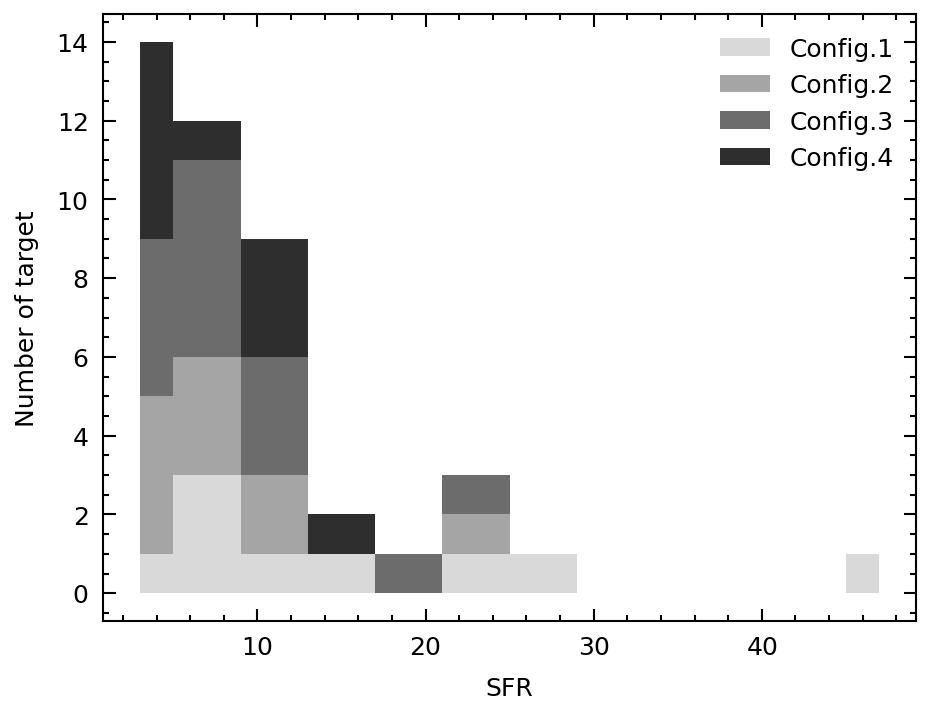

In [741]:
bin_start,bin_stop,bin_step=1,50,4
bin_edges = np.arange(bin_start, bin_stop + 1e-12, bin_step)


#logM = log10_safe(paired["stellar_mass"])
#s = pd.to_numeric(paired["Rs"], errors="coerce").dropna()
#counts, _ = np.histogram(s, bins=bin_edges)

centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

fig1=plt.figure(dpi=300)
#plt.step(centers, counts, linewidth=1.5,where="mid", label="All observed targets")
ax1=plt.gca()
#fig1,ax1=nice_hist(logM, bins=30, title="Selected targets: log10( Stellar Mass / Msun )",
#          xlabel="log10(M*)",alpha=0.2)
totalcounts=0
for ind,conf in enumerate(allconf):
    #logMconf = log10_safe(conf["stellar_mass"])
    #conf[conf["Rs"]]
    sconf1 = pd.to_numeric(conf["SFR"], errors="coerce")
    #sconf1[np.isnan(sconf1)] = 27
    counts, _ = np.histogram(sconf1, bins=bin_edges)
    ax1.fill_between(centers,totalcounts,totalcounts+counts,step="mid",color=gray_map[conf["config"].to_list()[0]],edgecolor="none", label=f"Config.{ind+1}")
    totalcounts+=counts
    #ax1.step(centers, totalcounts,color=f"C{ind+1}", linewidth=1.5, label=f"Config.{ind+1}")
ax1.set_xlabel("SFR")
ax1.set_ylabel("Number of target")
ax1.legend()
plt.show()

# Plot results from the LyC22 project

In [317]:
folder="/disk/bifrost/yuanze/KBSS/JWST_cycle5/"
line_LyC22 = pd.read_csv(
            folder+"lime_all_LyC22_eqw_dereddened_20250526.txt",
            sep=r" ",
            engine="python",
            quotechar='"',
            #comment="#",
            skip_blank_lines=True
        )
abundance_LyC22 = pd.read_csv(
            folder+"abundances_direct.dat",
            sep=r"\s+",
            engine="python",
            quotechar='"',
            #comment="#",
            skip_blank_lines=True
        )
LyC22_merged=line_LyC22.merge(abundance_LyC22, right_on="ID_MSA", left_on="ID_MSA", how="left")

In [318]:
ID_MSA=LyC22_merged["ID_MSA"].to_list()
o3_5007=np.array([LyC22_merged["O3_5007A_profile_flux"].to_numpy(),LyC22_merged["O3_5007A_profile_flux_err"].to_numpy()])
o3_4363=np.array([LyC22_merged["O3_4363A_profile_flux"].to_numpy(),LyC22_merged["O3_4363A_profile_flux_err"].to_numpy()])
O_H=np.array([LyC22_merged["O/H"].to_numpy(),LyC22_merged["O/H"].to_numpy()])

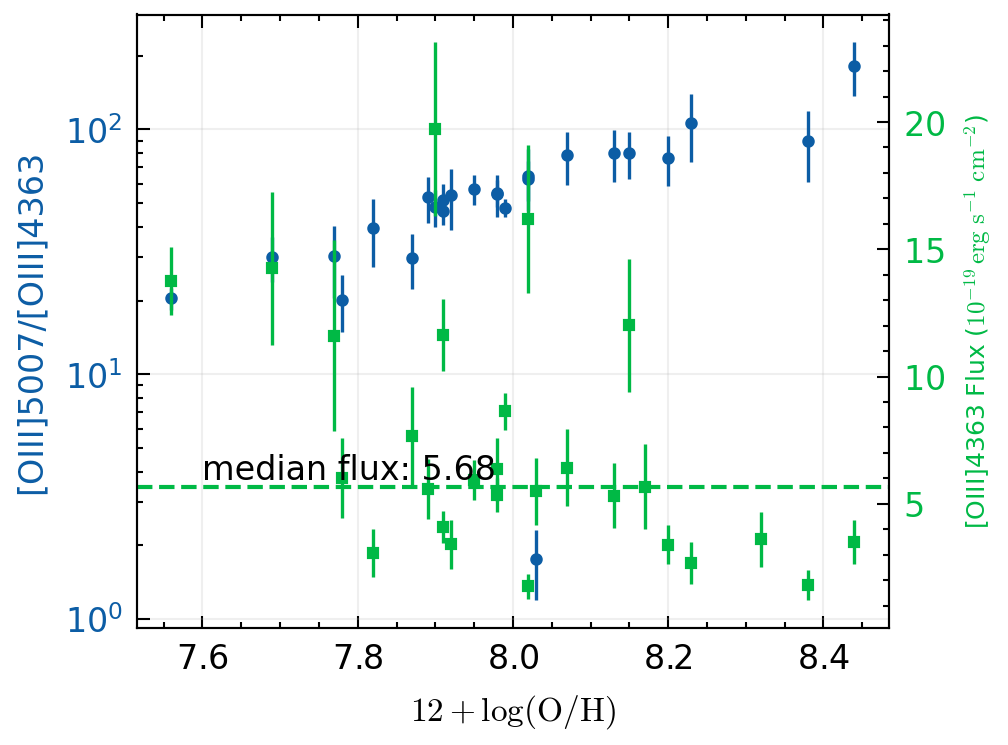

In [319]:
# assume: O_H[0], o3r, o3r_err already defined as in your snippet
# define your second series (edit these!)
# y2 = ...
# y2_err = ...
import scienceplots
plt.style.use(["science",'no-latex'])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":8,
"legend.fancybox":True})

o3r=o3_5007[0,:]/o3_4363[0,:] 
o3r_err=o3r*np.sqrt((o3_4363[1,:]/o3_4363[0,:])**2+(o3_5007[1,:]/o3_5007[0,:])**2) 
o3r_err[o3r_err<1e-5]=np.nan

import matplotlib.pyplot as plt

fig, ax = plt.subplots(dpi=300)

# pick two distinct default colors from the Matplotlib cycle
c1, c2 = plt.rcParams['axes.prop_cycle'].by_key()['color'][:2]

# LEFT axis — [OIII]5007/[OIII]4363
ax.errorbar(O_H[0], o3r, yerr=o3r_err, fmt='o', ms=2, lw=0.8,
            color=c1, label='[OIII]5007/[OIII]4363')
ax.set_xlabel(r'$12+\log(\mathrm{O/H})$')
ax.set_ylabel(r'[OIII]5007/[OIII]4363', color=c1)
ax.tick_params(axis='y', labelcolor=c1)
ax.set_yscale('log')
ax.grid(True, which='major', axis='both', alpha=0.2)

# RIGHT axis — second dataset
ax2 = ax.twinx()  # shares the same x
ax2.errorbar(O_H[0], o3_4363[0,:]*1e19, yerr=o3_4363[1,:]*1e19, fmt='s', ms=2, lw=0.8,
             color=c2, label='[OIII]4363 Flux')
ax2.set_ylabel(r"[OIII]4363 Flux ($10^{-19}\,\rm erg~s^{-1}~cm^{-2}$)",fontsize=6, color=c2)
ax2.tick_params(axis='y', labelcolor=c2)
OIIImedian=np.nanmedian(o3_4363[0,:][~np.isnan(O_H[0])])*1e19
ax2.axhline(y=OIIImedian,ls="--",color=c2)
ax2.text(7.6,OIIImedian,f"median flux: {OIIImedian:.2f}",va="bottom")
# optional: nudge the right spine outward a bit for clarity
ax2.spines['right'].set_position(('axes', 1.0))
#ax2.set_yscale("log")
# one combined legend
#h1, l1 = ax.get_legend_handles_labels()
#h2, l2 = ax2.get_legend_handles_labels()
#ax.legend(h1+h2, l1+l2, loc='upper right', frameon=False)

fig.tight_layout()
plt.show()


In [320]:
np.sum(o3_4363[0,:]*1e19<4)

38

In [ ]:
np.sum(o3_4363[0,:]*1e19>4)

In [853]:
o3_4363[0,:][~np.isnan(O_H[0])]*1e19

array([ 3.48378942,  5.31436944, 12.01606116, 11.60666467,  6.35646289,
        2.66829022,  5.67762958,  5.56221913,  6.02949822,  3.60267417,
        6.40936404, 16.19664624,  1.8025646 , 14.2581524 ,  5.91910954,
        8.64455529,  4.10010781,  3.40449784,  3.39833111,  5.33295025,
       13.75900341,  3.05859612,  5.48323807, 19.72283788, 11.63715974,
        7.66365905,  1.75185587])

In [851]:
np.nanmedian(o3_4363[0,:]*1e19)

5.392703698439844